# Understanding order book event data

The goal is to get an understanding of order book event data. With that, I will hopefully be able to get an intention on what features (e.g. signals) might be extracted and being fed to the reinforcement learner.

This notebook is inspired by work of [1] and [2].


In [1]:
%cd ..

/Volumes/Data/dev/ctc-executioner


In [44]:
import sys
from time import time
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
from math import floor, ceil
import datetime
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
import copy
from orderbook import *
import datetime as dt
import matplotlib.dates as md

plt.rcParams["font.family"] = "Monospace"
plt.grid(False)
plt.axis('on')
plt.style.use('dark_background')

## Load Events

First we load the event data (see [Wiki:Data:order-book-events](https://github.com/backender/ctc-executioner/wiki/2.-Data#order-book-events)) into a Pandas dataframe.

In [138]:
cols = ["ts", "seq", "size", "price", "is_bid", "is_trade"]
events = pd.read_table('ob-2.tsv', sep='\t', names=cols, index_col="seq")
events.sort_index()

ts      size         price  is_bid  is_trade
seq                                                           
624233  1.519302e+09  0.000000  10246.310000       1         0
624233  1.519302e+09  0.565000  10234.810000       1         0
624234  1.519302e+09  0.291099  10282.000000       1         0
624234  1.519302e+09  0.565000  10232.670000       1         0
624234  1.519302e+09  0.000000   9671.000000       1         0
624234  1.519302e+09  0.000000   9670.200000       1         0
624234  1.519302e+09  1.630000  10329.000000       0         0
624234  1.519302e+09  0.000000  10333.000000       0         0
624235  1.519302e+09  1.722956   9670.200000       1         0
624235  1.519302e+09  0.004126   9671.000000       1         0
624235  1.519302e+09  0.000000  10101.000000       1         0
624235  1.519302e+09  0.000000  10207.312100       1         0
624235  1.519302e+09  0.098753  10101.000000       1         0
624236  1.519302e+09  0.787111  10205.696000       1         0
624236  1.519302e+09  0.000000   9670.200000       1         0
624236  1.519302e+09  3.241548  10550.000000       0         0
624237  1.519302e+09  0.037232  10150.000000       1         0
624237  1.519302e+09  0.000000   9671.000000       1         0
624238  1.519302e+09  0.000873  11429.904337       0         0
624238  1.519302e+09  0.000000  10372.749100       0         0
624238  1.519302e+09  0.947436  10272.672409       1         0
624238  1.519302e+09  1.092836  10161.016000       1         0
624238  1.519302e+09  0.000000   9671.000000       1         0
624239  1.519302e+09  0.006006  10161.016000       1         0
624239  1.519302e+09  0.000000  10150.000000       1         0
624239  1.519302e+09  0.787698  10385.056101       0         0
624239  1.519302e+09  0.000000  11429.904337       0         0
624240  1.519302e+09  0.005674  10238.880000       1         0
624240  1.519302e+09  0.000000  10210.780000       1         0
624240  1.519302e+09  0.006106  10180.372114       1         0
...              ...       ...           ...     ...       ...
654665  1.519340e+09  0.000000  10127.670000       0         0
654665  1.519340e+09  2.229350  10880.000000       0         0
654665  1.519340e+09  0.020000  10880.365407       0         0
654665  1.519340e+09  0.002338  10883.890633       0         0
654665  1.519340e+09  0.589000   9801.080000       1         0
654665  1.519340e+09  0.000000   9425.800000       1         0
654665  1.519340e+09  0.000000   9966.610000       0         0
654665  1.519340e+09  0.000000   9946.610000       0         0
654665  1.519340e+09  0.000000   9956.610000       0         0
654665  1.519340e+09  0.000000  10127.670000       0         0
654665  1.519340e+09  2.229350  10880.000000       0         0
654665  1.519340e+09  0.000000   9966.610000       0         0
654665  1.519340e+09  0.531280   9916.600000       0         0
654665  1.519340e+09  0.000000   9956.610000       0         0
654665  1.519340e+09  0.000000   9946.610000       0         0
654665  1.519340e+09  0.531280   9916.600000       0         0
654665  1.519340e+09  0.000000   9425.800000       1         0
654665  1.519340e+09  0.589000   9801.080000       1         0
654665  1.519340e+09  0.002338  10883.890633       0         0
654665  1.519340e+09  0.020000  10880.365407       0         0
654665  1.519340e+09  2.229350  10880.000000       0         0
654665  1.519340e+09  0.000000  10127.670000       0         0
654665  1.519340e+09  0.000000   9966.610000       0         0
654665  1.519340e+09  0.000000   9956.610000       0         0
654665  1.519340e+09  0.531280   9916.600000       0         0
654665  1.519340e+09  0.000000   9425.800000       1         0
654665  1.519340e+09  0.589000   9801.080000       1         0
654665  1.519340e+09  0.020000  10880.365407       0         0
654665  1.519340e+09  0.000000   9946.610000       0         0
654665  1.519340e+09  0.002338  10883.890633       0         0

[480480 rows x 5 columns]

In [139]:
duration = lambda es: print((float(es['ts'].iloc[-1]) - float(es['ts'].iloc[0])) / 60, "minutes")
duration(events)

625.9324333270391 minutes


Let's take a subset of this data set

In [140]:
events = events[1000:30000]
duration(events)

65.39081667264303 minutes


## Generate order book

In [141]:
ob_dict = Orderbook.generateDictFromEvents(events) # expensive

In [142]:
ob = Orderbook()
ob.loadFromDict(ob_dict)
# Wipe first few states as bids and asks were not quiet settled
ob.states.pop(0)
ob.states.pop(0)
ob.states.pop(0)
ob.states.pop(0)

----------ORDERBOOK STATE----------
DateTime: 1519302350.92
Price: 11408.0
Buyers: [10211.00010005: 0.28548978, 10130.00000002: 0.17685255, 10070.45926146: 0.78711106, 9667.0: 0.00103444, 9665.0: 0.01513035, 9664.0: 0.13019913]
Sellers: [10275.3: 0.537, 11400.00000001: 0.02426331, 11400.2: 0.05214472, 11401.0934466: 0.09225146, 11408.0: 0.87879589]
Market Vars: {}
----------ORDERBOOK STATE----------

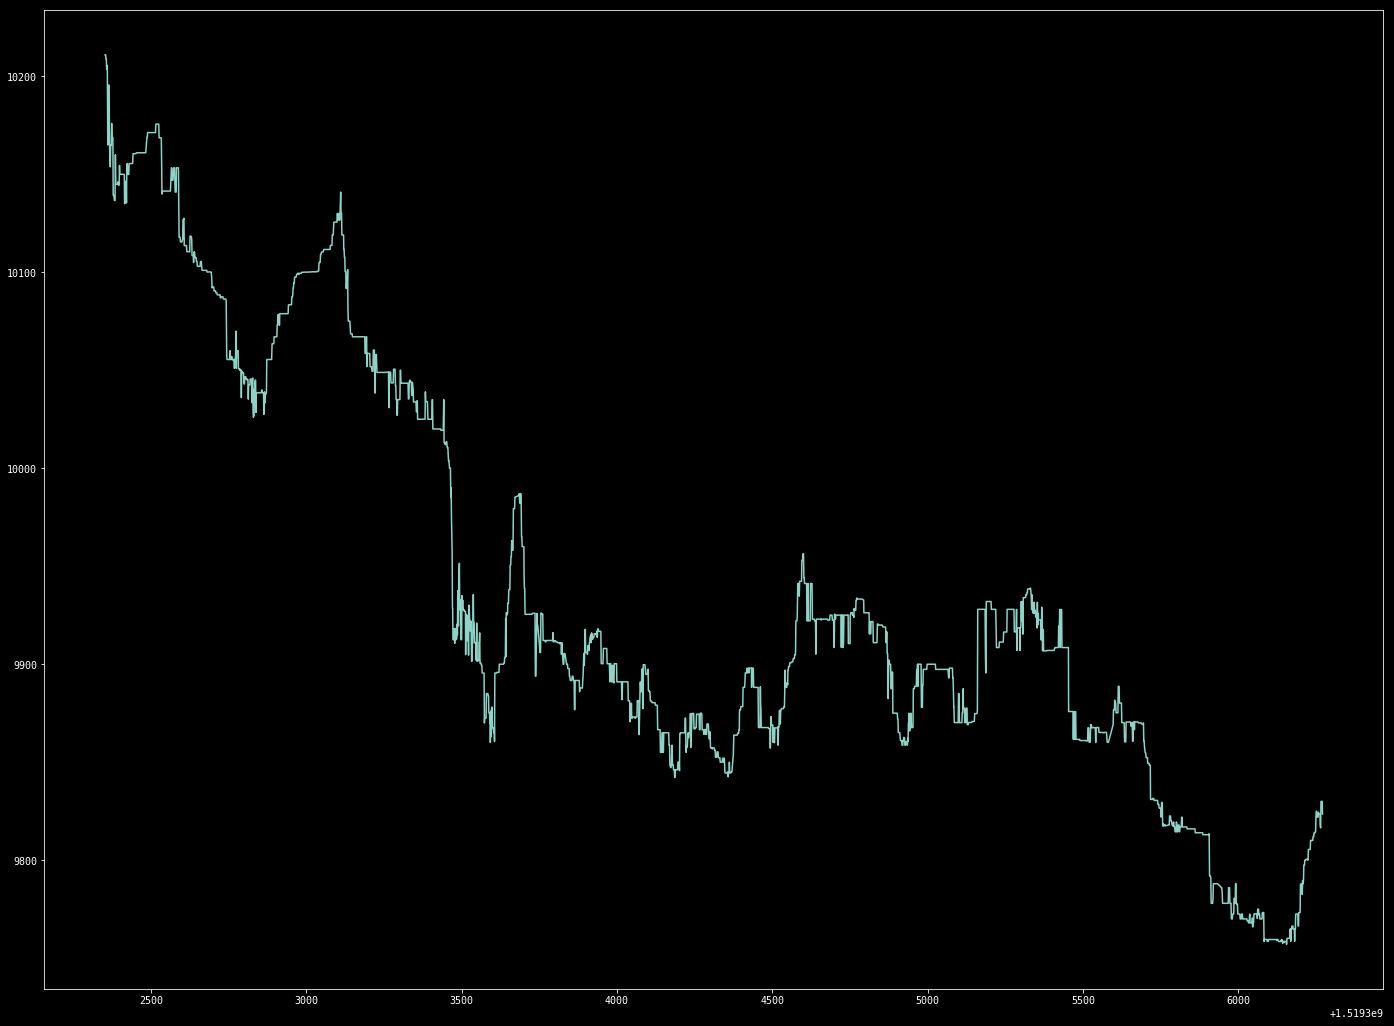

In [143]:
plt.figure(figsize=(24, 18))
ob.plot(show_bidask=False)

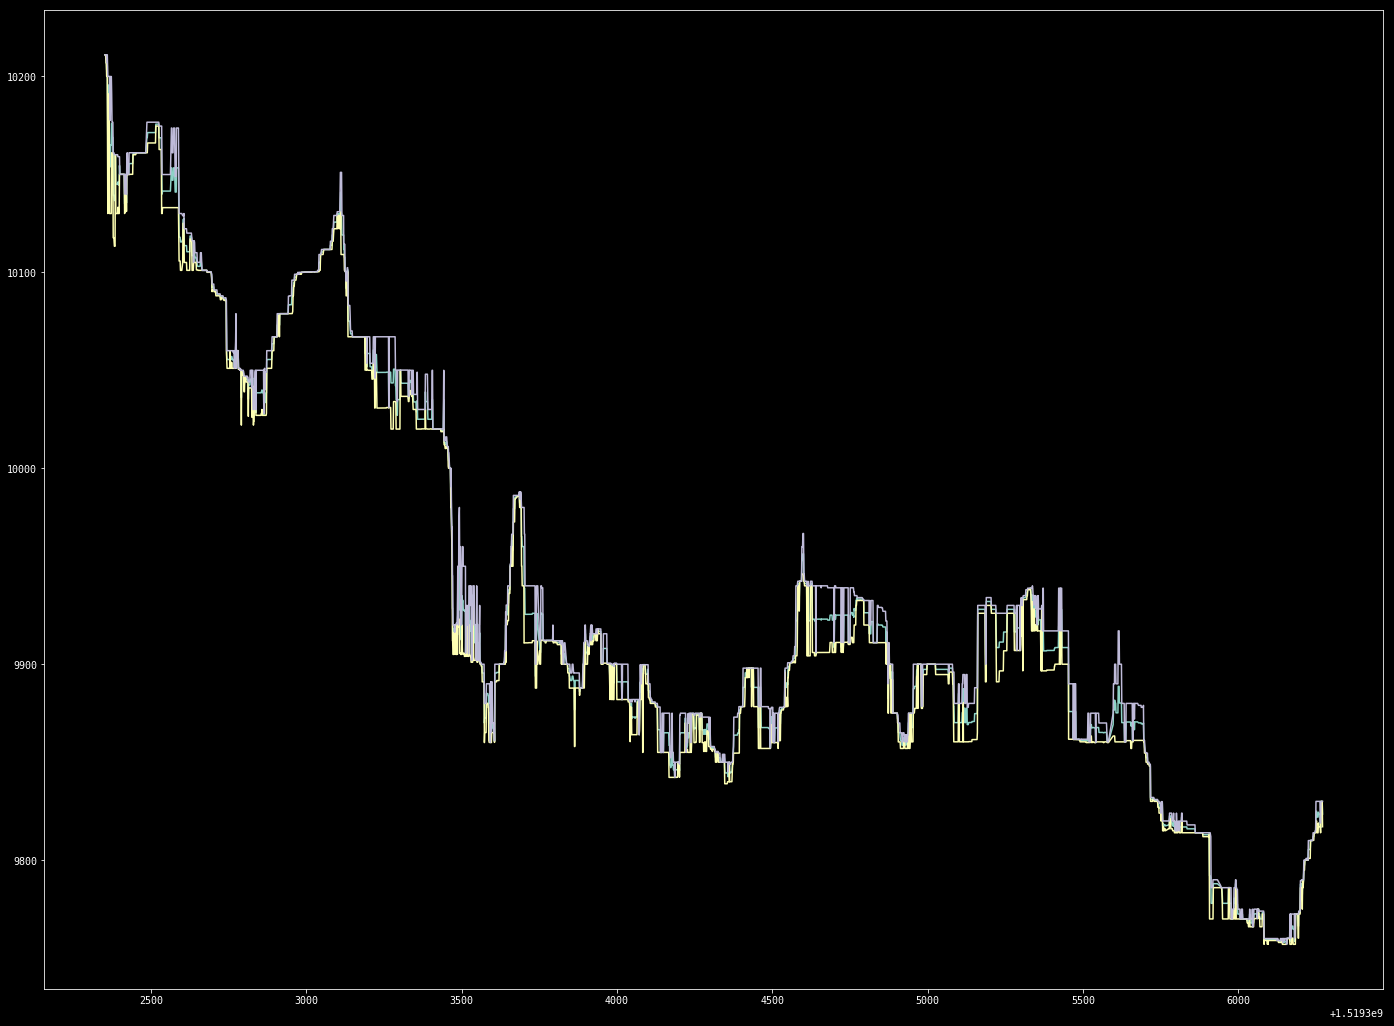

In [144]:
plt.figure(figsize=(24, 18))
ob.plot(show_bidask=True, max_level=0)

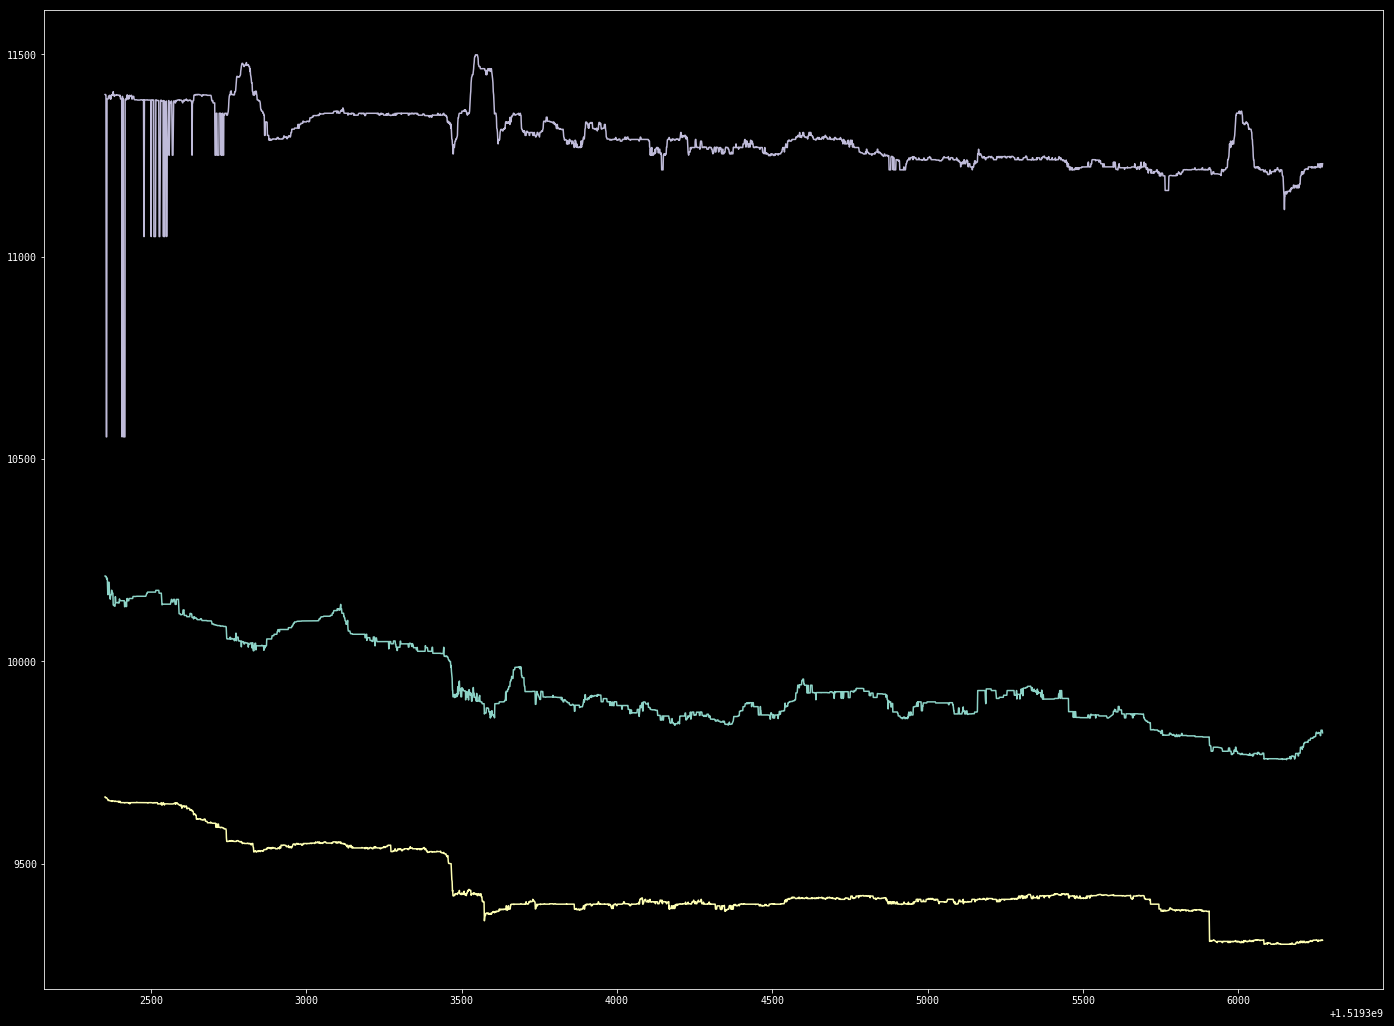

In [145]:
plt.figure(figsize=(24, 18))
ob.plot(show_bidask=True, max_level=-1)

## Prices

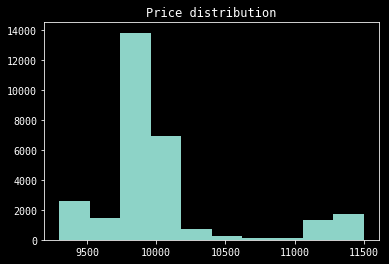

In [146]:
prices = np.array(events["price"])
plt.hist(prices)
plt.title("Price distribution")
plt.show()

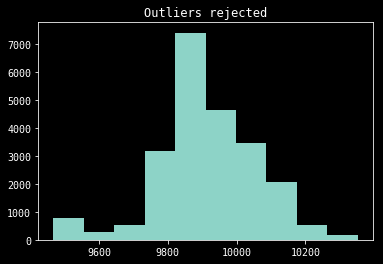

In [147]:
def reject_outliers(data, m = 2.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
    return data[s<m]

rejected = reject_outliers(prices, m=4)
plt.hist(rejected)
plt.title("Outliers rejected")
plt.show()

### Price levels

In [174]:
result = events.as_matrix().tolist()

In [175]:
def to_updates(events, prices, tick_bins_cnt = 2000, step_bins_cnt = 2000):
    sizes, boundaries = np.histogram(prices, tick_bins_cnt)
    def into_tick_bin(price):
        for (s, b) in zip(boundaries, boundaries[1:]):
            if b > price > s:
                return s
        return False

    # TODO: result as parameter (extracted result variable as its computationally expensive)
    min_ts = result[0][0]
    max_ts = result[-1][0]
    step_thresholds = range(int(floor(min_ts)), int(ceil(max_ts)), int(floor((max_ts - min_ts)/(step_bins_cnt))))
    def into_step_bin(time):
        for (s, b) in zip(step_thresholds, step_thresholds[1:]):
            if b > time > s:
                return b
        return False

    updates = {}
    for row in result:
        ts, size, price, is_bid, is_trade = row
        price = into_tick_bin(price)
        time = into_step_bin(ts)
        if not price or not time:
            continue
        if price not in updates:
            updates[price] = {}
        if time not in updates[price]:
            updates[price][time] = 0
        updates[price][time] += size
    return updates

def plot_price_levels(updates, zorder=0, max_threshold=100, min_threshold=0.5):
    ys = []
    xmins = []
    xmaxs = []
    colors = []

    for price, vdict in updates.items():
        vtuples = vdict.items()
        vtuples = sorted(vtuples, key=lambda tup: tup[0])
        for (t1, s1), (t2, s2) in zip(vtuples, vtuples[1:]): # bigram
            xmins.append(t1)
            xmaxs.append(t2)
            ys.append(price)
            if s1 < min_threshold:
                colors.append((0, 0, 0))
            elif s1 > max_threshold:
                colors.append((0, 1, 1))
            else:
                colors.append((0, s1/max_threshold, s1/max_threshold))
    plt.hlines(ys, xmins, xmaxs, color=colors, lw=3, alpha=1, zorder=zorder)
    # plt.colorbar()

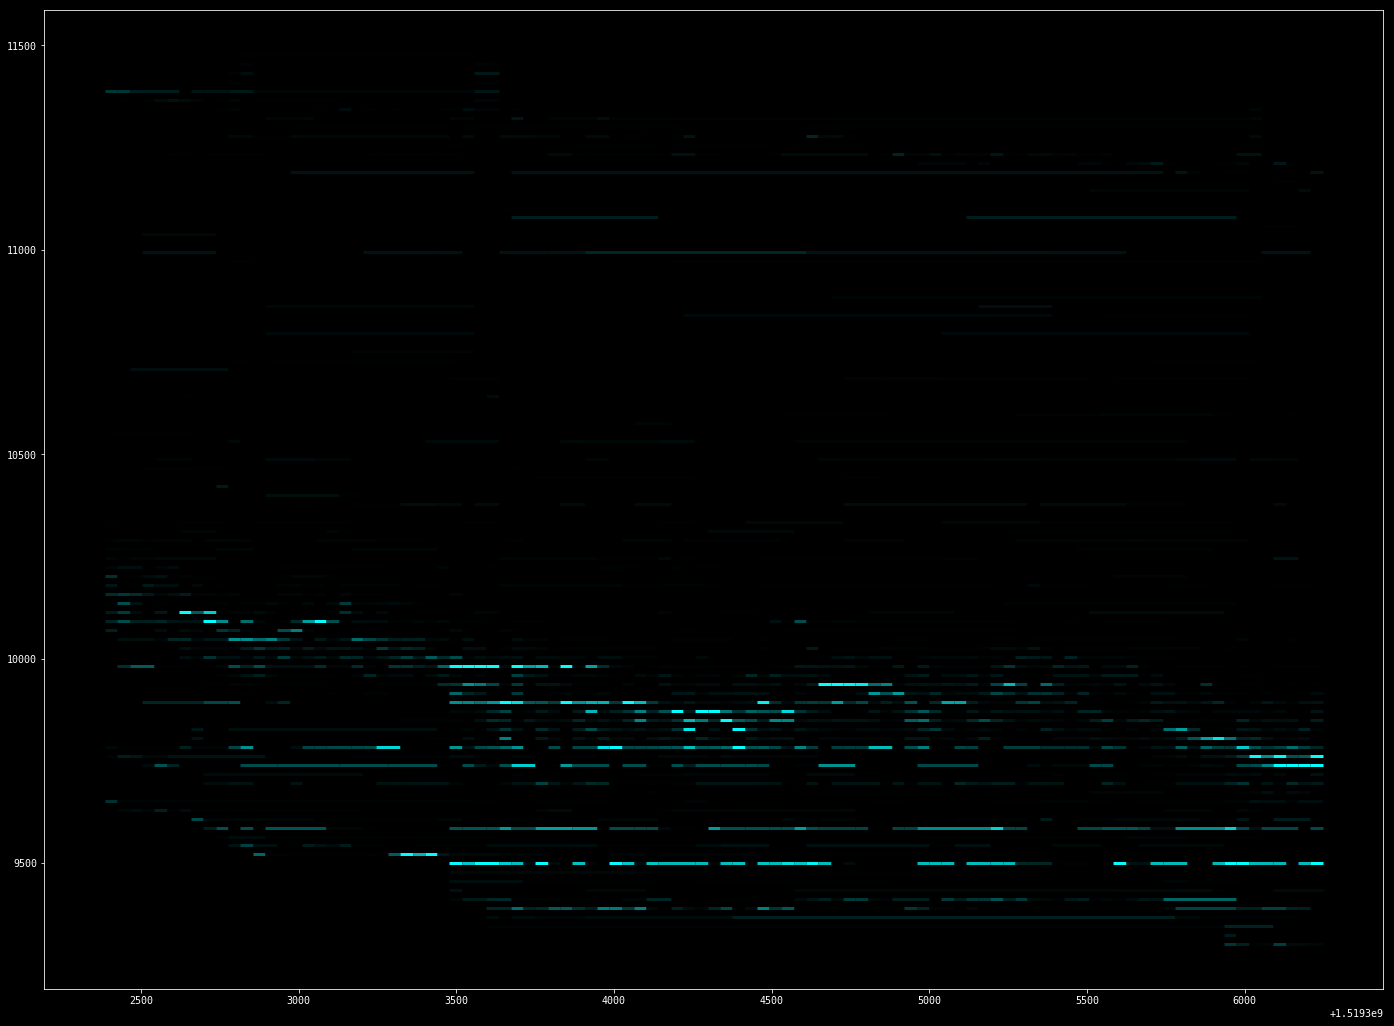

In [179]:
updates = to_updates(events, prices, tick_bins_cnt = 100, step_bins_cnt = 100)
plt.figure(figsize=(24, 18))
plot_price_levels(updates, max_threshold=100, min_threshold=0.01, zorder=1)
plt.show()

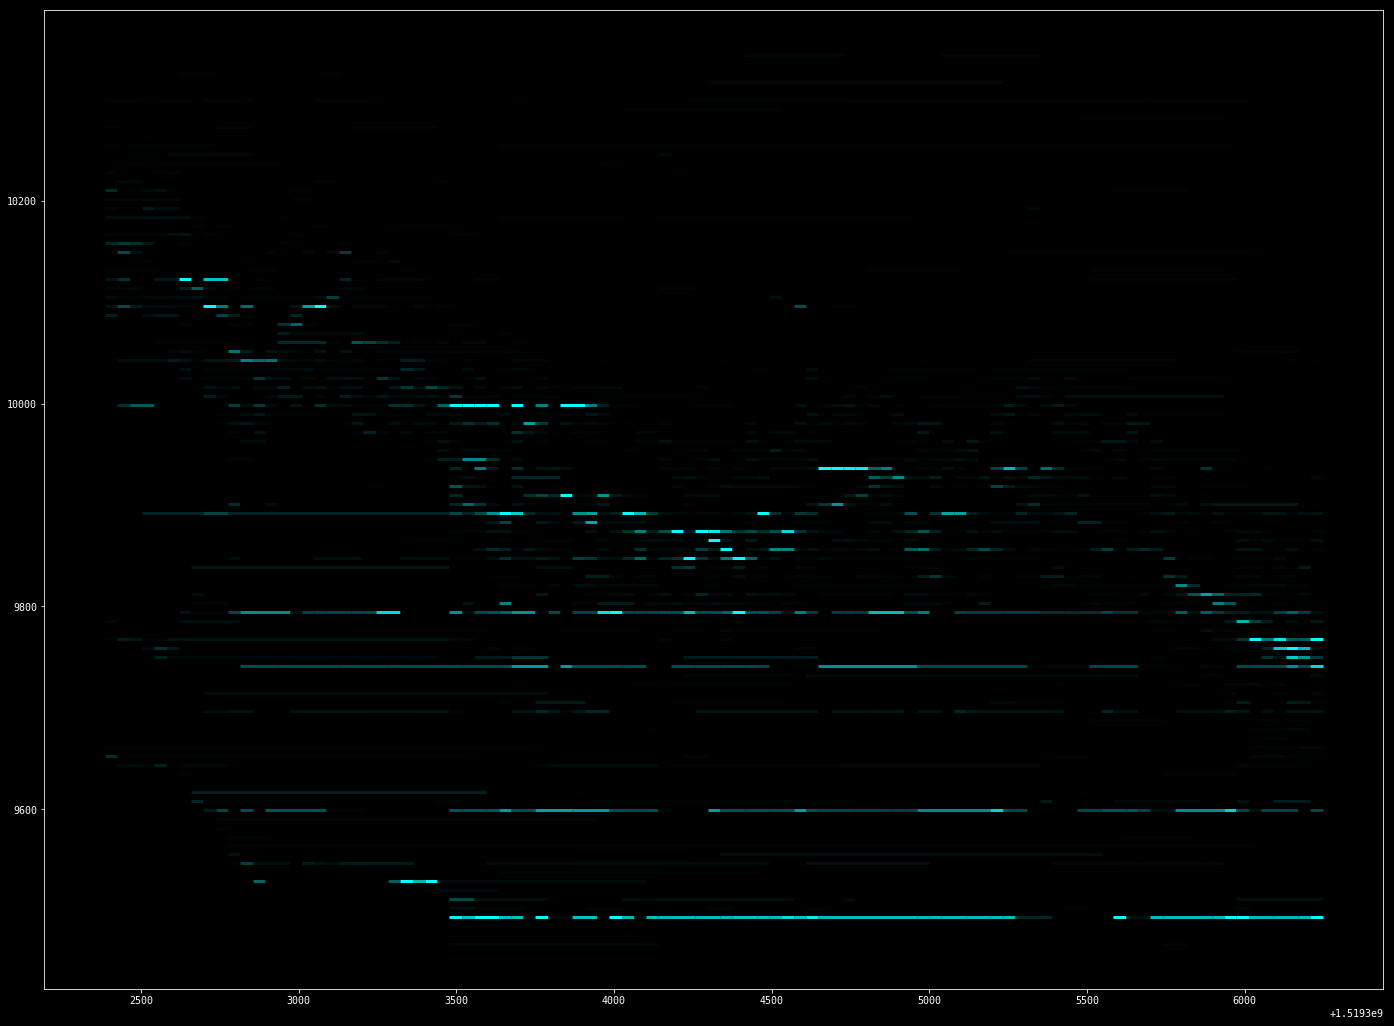

In [178]:
updates = to_updates(events, rejected, tick_bins_cnt = 100, step_bins_cnt = 100) # expensive
plt.figure(figsize=(24, 18))
plot_price_levels(updates, max_threshold=100, min_threshold=0.01, zorder=1)
plt.show()

## Bids vs. Asks

In [148]:
def getCategories():
    cancelled = []
    created = []
    current_level = {}
    for seq, (ts, size, price, is_bid, is_trade) in events.sort_index().iterrows():
        if not is_trade:
            prev = current_level[price] if price in current_level else 0
            if (size == 0 or size <= prev):
                cancelled.append((ts, seq, prev - size, price, is_bid, is_trade))
            elif (size > prev):
                created.append((ts, seq, size - prev, price, is_bid, is_trade))
            else: # size == prev
                raise Exception("Impossible")

        current_level[price] = size

    cancelled = pd.DataFrame.from_records(cancelled, columns=cols, index="seq")
    created = pd.DataFrame.from_records(created, columns=cols, index="seq")
    trades = events[events['is_trade'] == 1]
    # sanity check
    assert len(cancelled) + len(created) + len(trades) == len(events)
    return (created, cancelled, trades)

In [149]:
created, cancelled, trades = getCategories()

In [150]:
def plotBidAskPie(events):
    is_bids = events["is_bid"]
    total_events_cnt = is_bids.size
    bids = np.sum(is_bids)
    asks = total_events_cnt - bids

    plt.pie([bids, asks])
    plt.legend(["bids", "asks"])
    plt.title("bid/ask")
    plt.show()

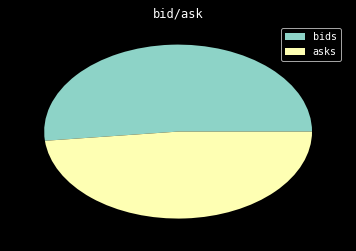

In [151]:
plotBidAskPie(events)

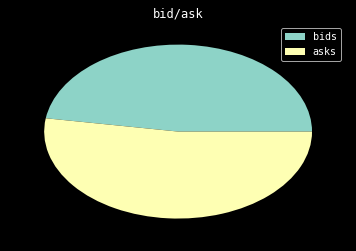

In [152]:
plotBidAskPie(trades)

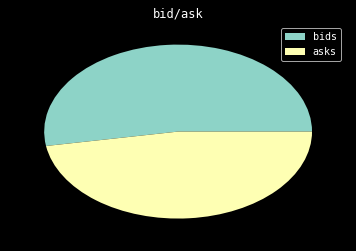

In [153]:
plotBidAskPie(created)

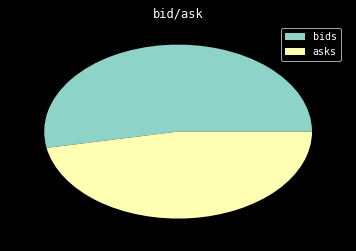

In [154]:
plotBidAskPie(cancelled)

In [202]:
def plot_ob(bidask, bps=.25):
    # bps: basis points

    best_bid = max(bidask["bids"].keys())
    best_ask = min(bidask["asks"].keys())
    worst_bid = best_bid * (1 - bps)
    worst_ask = best_bid * (1 + bps)
    filtered_bids = sorted(filter(lambda kv: kv[0] >= worst_bid, bidask['bids'].items()), key=lambda x:-x[0])
    filtered_asks = sorted(filter(lambda kv: kv[0] <= worst_ask, bidask['asks'].items()), key=lambda x:+x[0])

    bsizeacc = 0
    bhys = []    # bid - horizontal - ys
    bhxmins = [] # bid - horizontal - xmins
    bhxmaxs = [] # ...
    bvxs = []
    bvymins = []
    bvymaxs = []
    asizeacc = 0
    ahys = []
    ahxmins = []
    ahxmaxs = []
    avxs = []
    avymins = []
    avymaxs = []

    for (p1, s1), (p2, s2) in zip(filtered_bids, filtered_bids[1:]):
        bvymins.append(bsizeacc)
        if bsizeacc == 0:
            bsizeacc += s1
        bhys.append(bsizeacc)
        bhxmins.append(p2)
        bhxmaxs.append(p1)
        bvxs.append(p2)
        bsizeacc += s2
        bvymaxs.append(bsizeacc)

    for (p1, s1), (p2, s2) in zip(filtered_asks, filtered_asks[1:]):
        avymins.append(asizeacc)
        if asizeacc == 0:
            asizeacc += s1
        ahys.append(asizeacc)
        ahxmins.append(p1)
        ahxmaxs.append(p2)
        avxs.append(p2)
        asizeacc += s2
        avymaxs.append(asizeacc)

    plt.hlines(bhys, bhxmins, bhxmaxs, color="green")
    plt.vlines(bvxs, bvymins, bvymaxs, color="green")
    plt.hlines(ahys, ahxmins, ahxmaxs, color="red")
    plt.vlines(avxs, avymins, avymaxs, color="red")


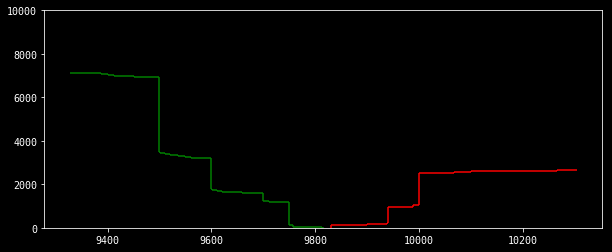

In [203]:
d_ts = max(ob_dict.keys())
d_ob = ob_dict[d_ts]
plt.figure(figsize=(10,4))
plot_ob(d_ob, bps=.05)
plt.ylim([0, 10000])
plt.show()

## Volumes

In [155]:
def plotVolumeMap(df, volFrom=None, volTo=None, log_scale=True):
    if volFrom:
        df = df[df["size"] >= volFrom]
    if volTo:
        df = df[df["size"] <= volTo]

    colors = list(map(lambda b: '#ffff00' if b else '#00ffff', df["is_bid"]))

    fig = plt.figure(figsize=(24, 18))
    ax = fig.add_subplot(111)
    if log_scale:
        ax.set_yscale('log')

    plt.scatter(df["ts"], df["size"], c=colors, s=5)
    plt.legend(["bid"])
    plt.show()

### Cancelled

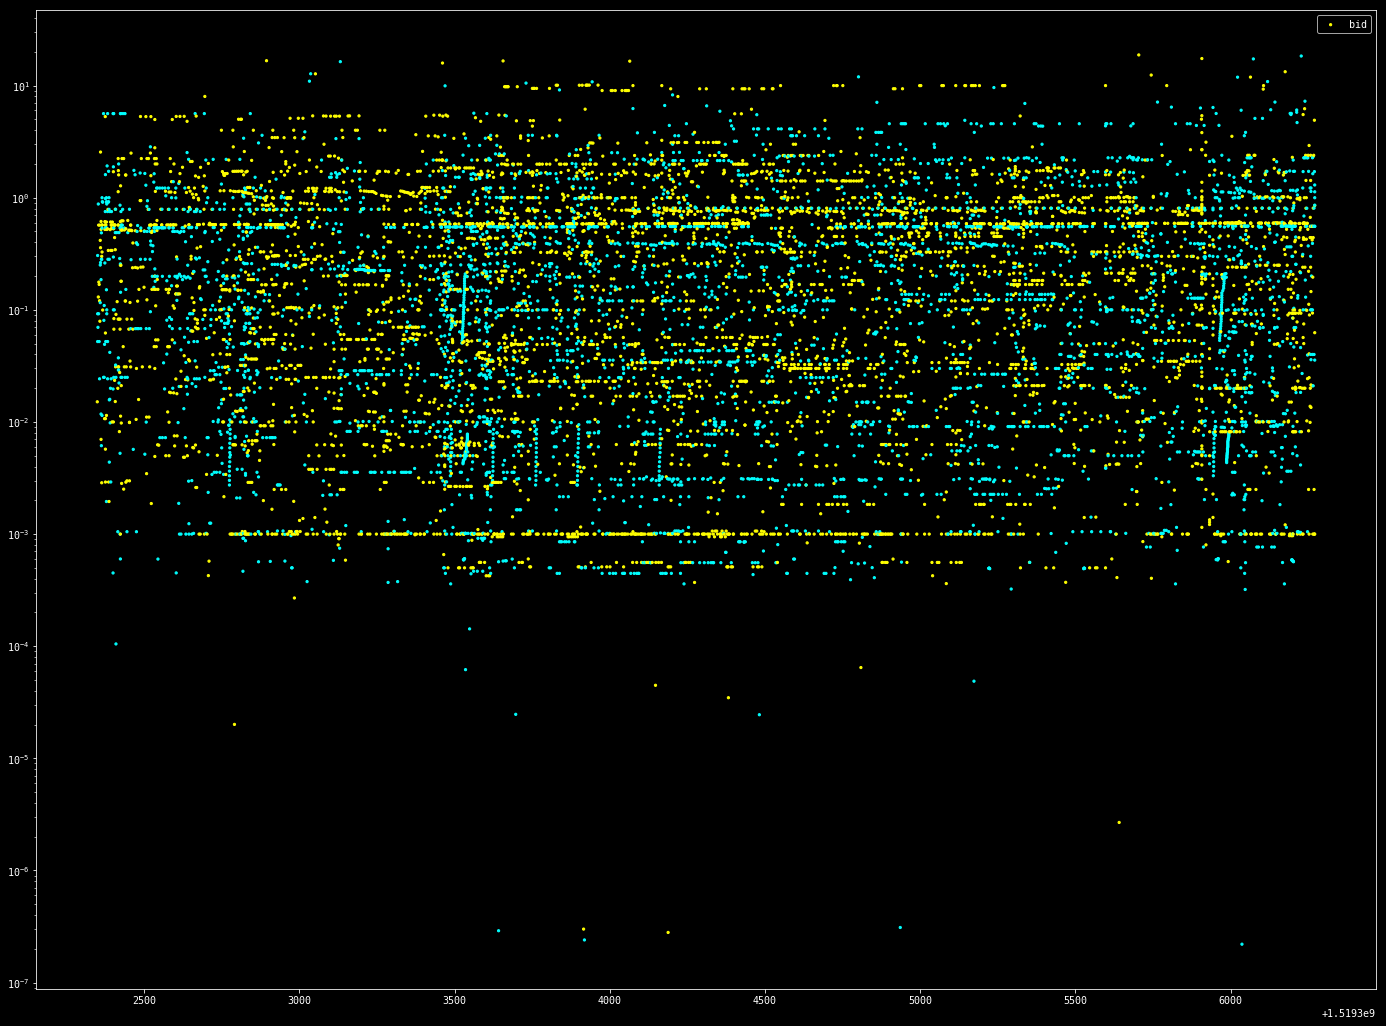

In [156]:
plotVolumeMap(cancelled, volFrom=0, volTo=20, log_scale=True)

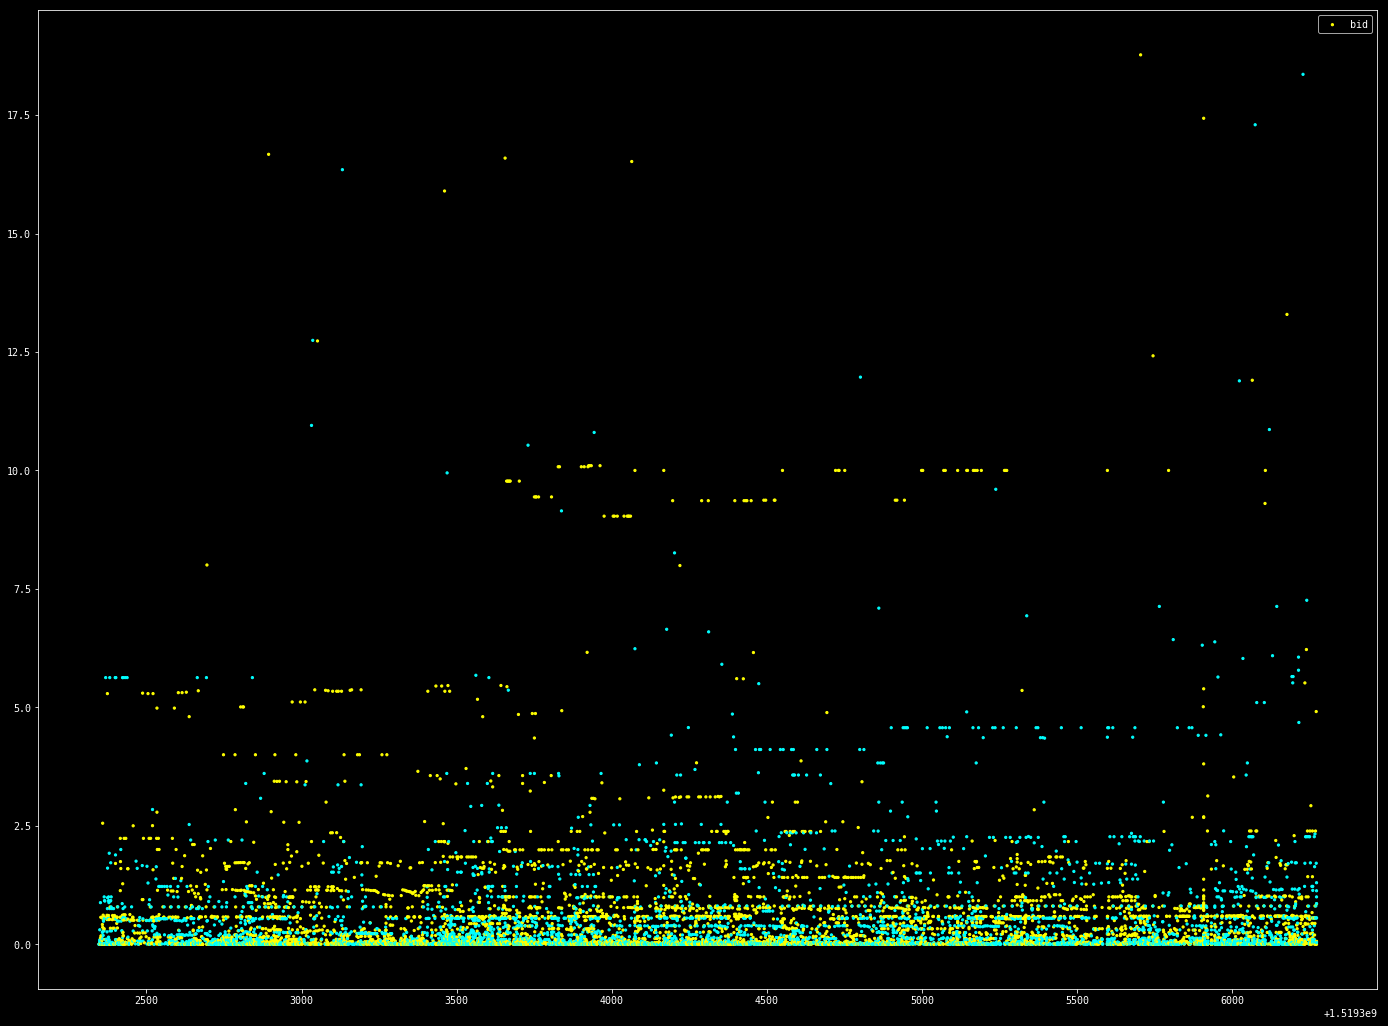

In [157]:
plotVolumeMap(cancelled, volFrom=0, volTo=20, log_scale=False)

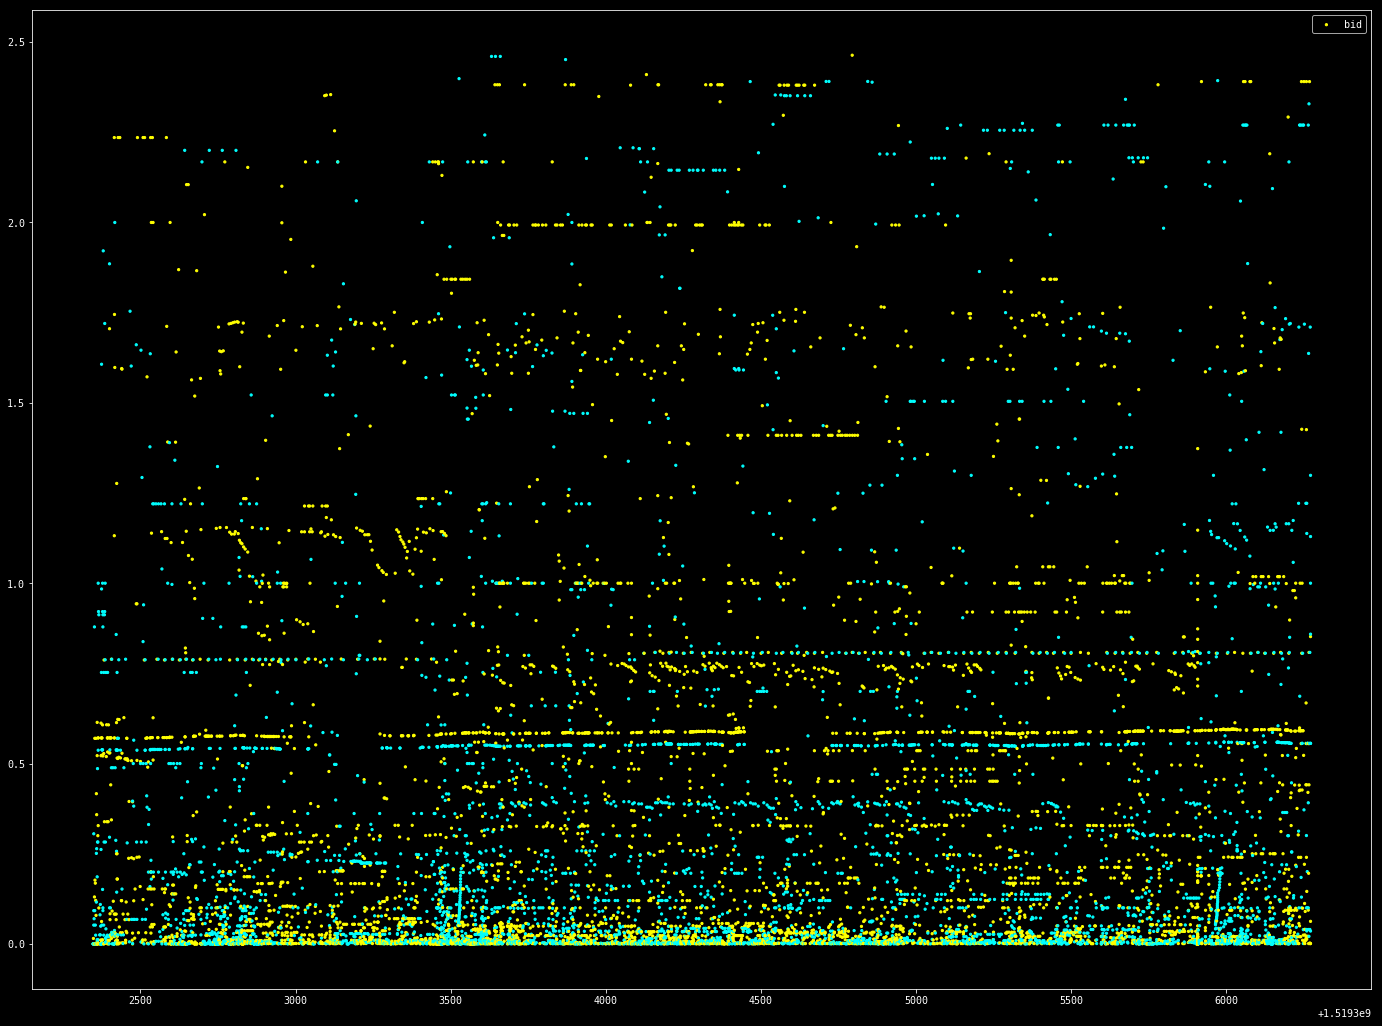

In [158]:
plotVolumeMap(cancelled, volFrom=0, volTo=2.5, log_scale=False)

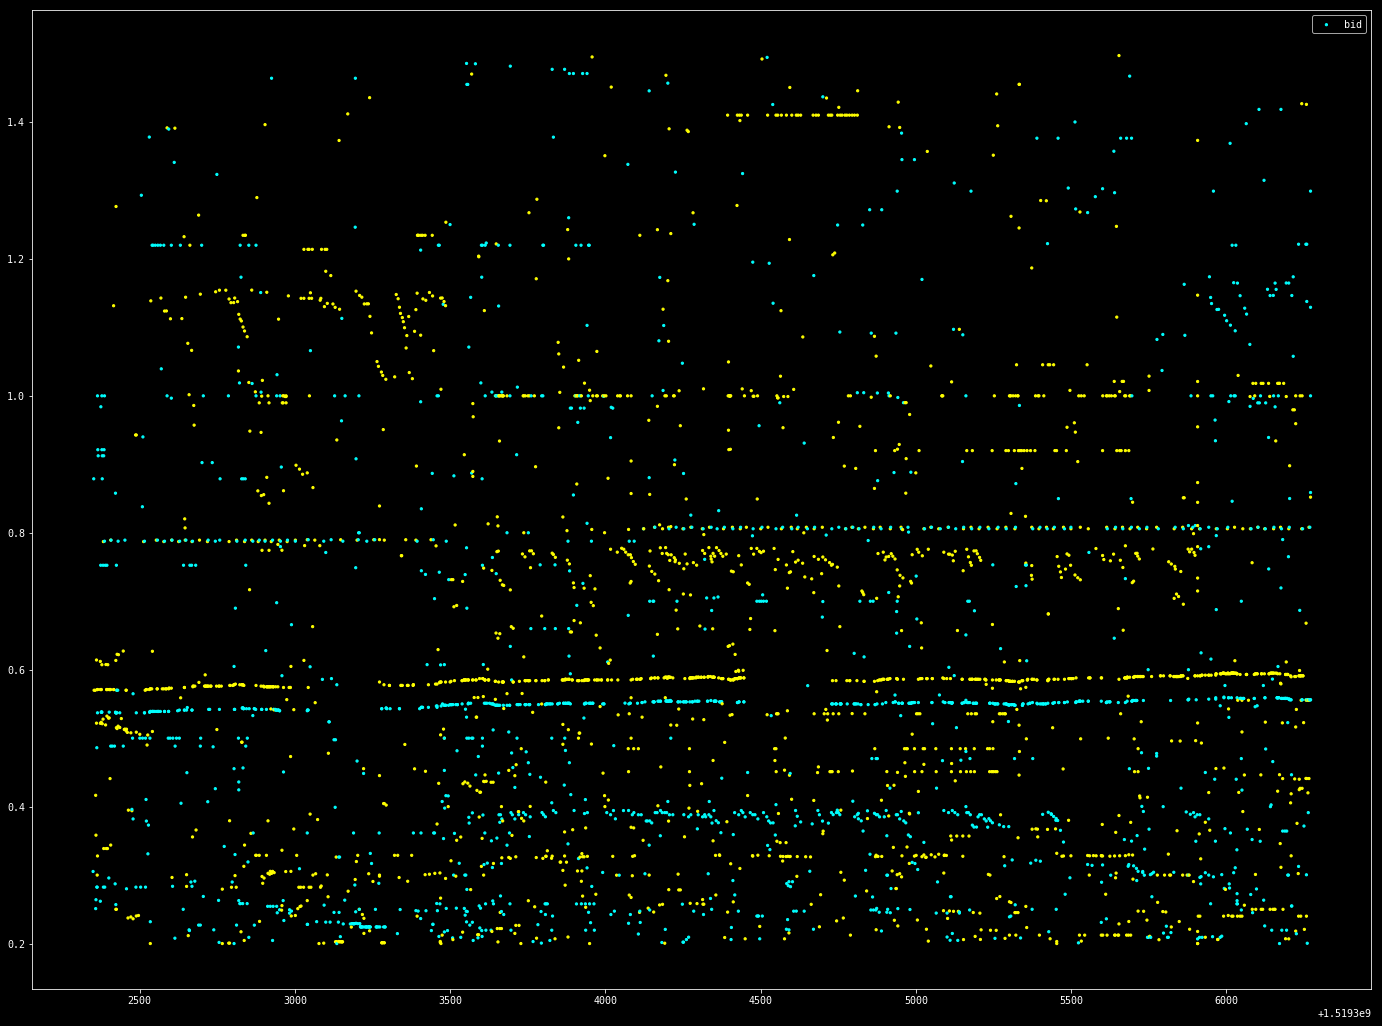

In [159]:
plotVolumeMap(cancelled, volFrom=0.2, volTo=1.5, log_scale=False)

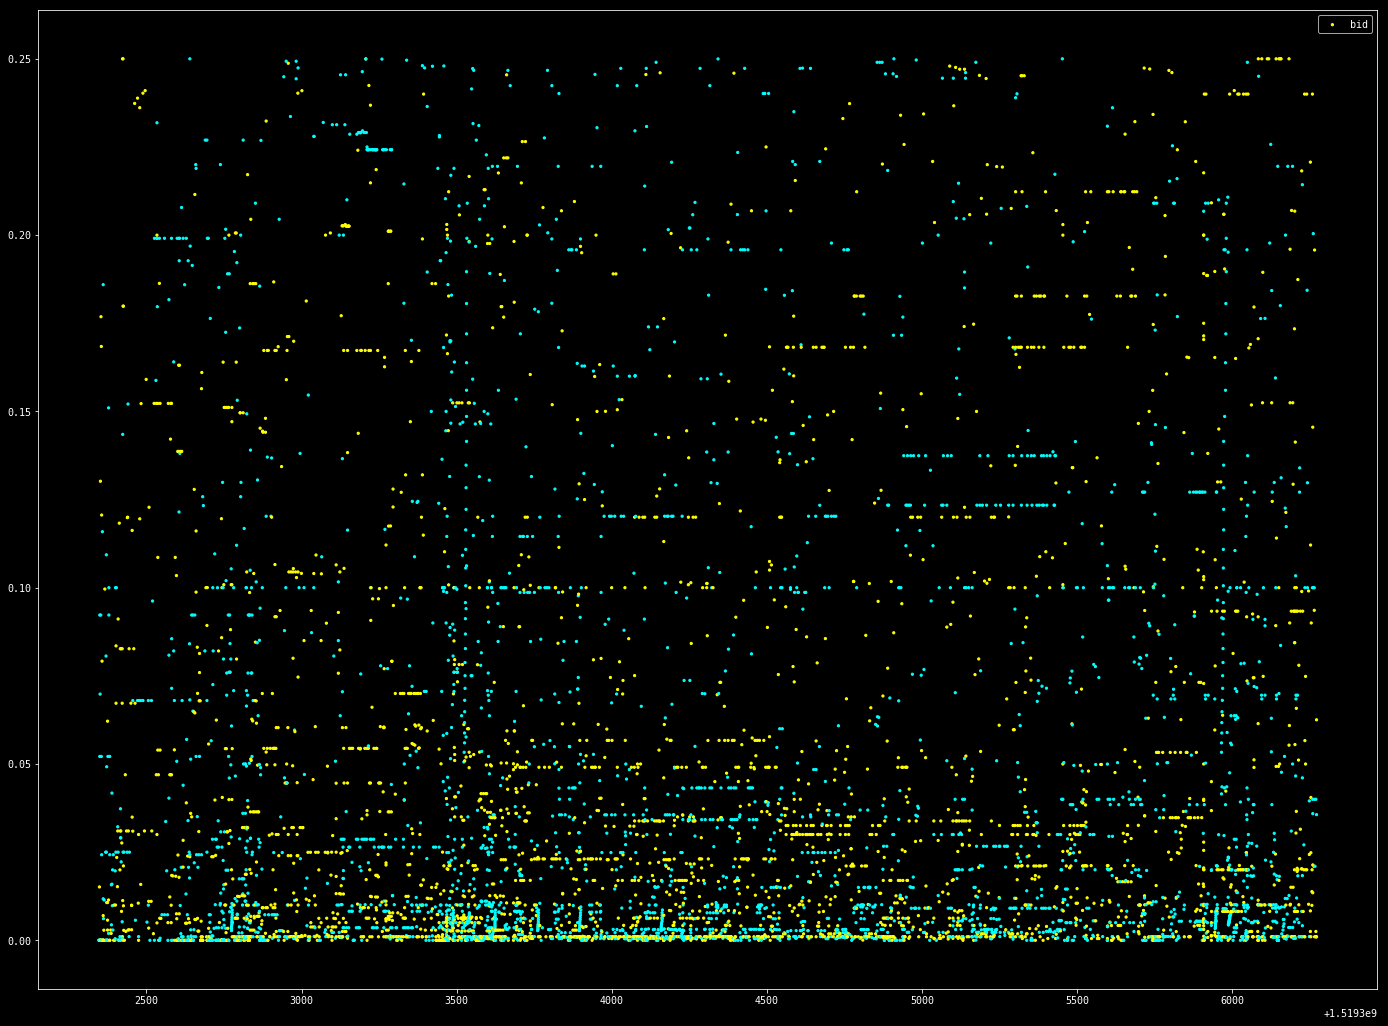

In [160]:
plotVolumeMap(cancelled, volFrom=0.0, volTo=0.25, log_scale=False)

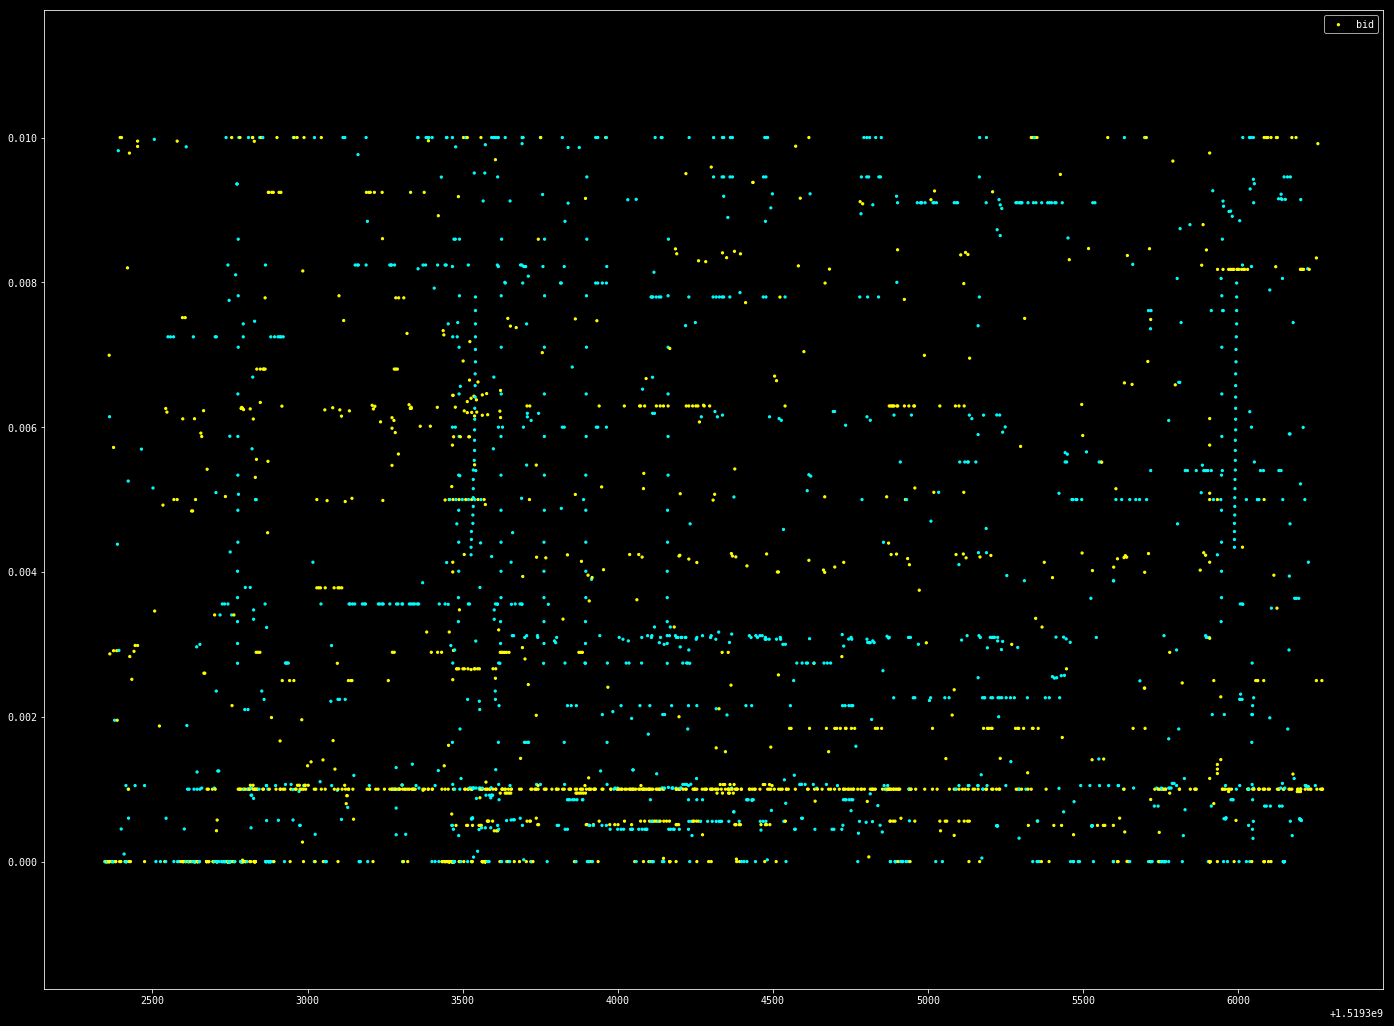

In [161]:
plotVolumeMap(cancelled, volFrom=0.0, volTo=0.01, log_scale=False)

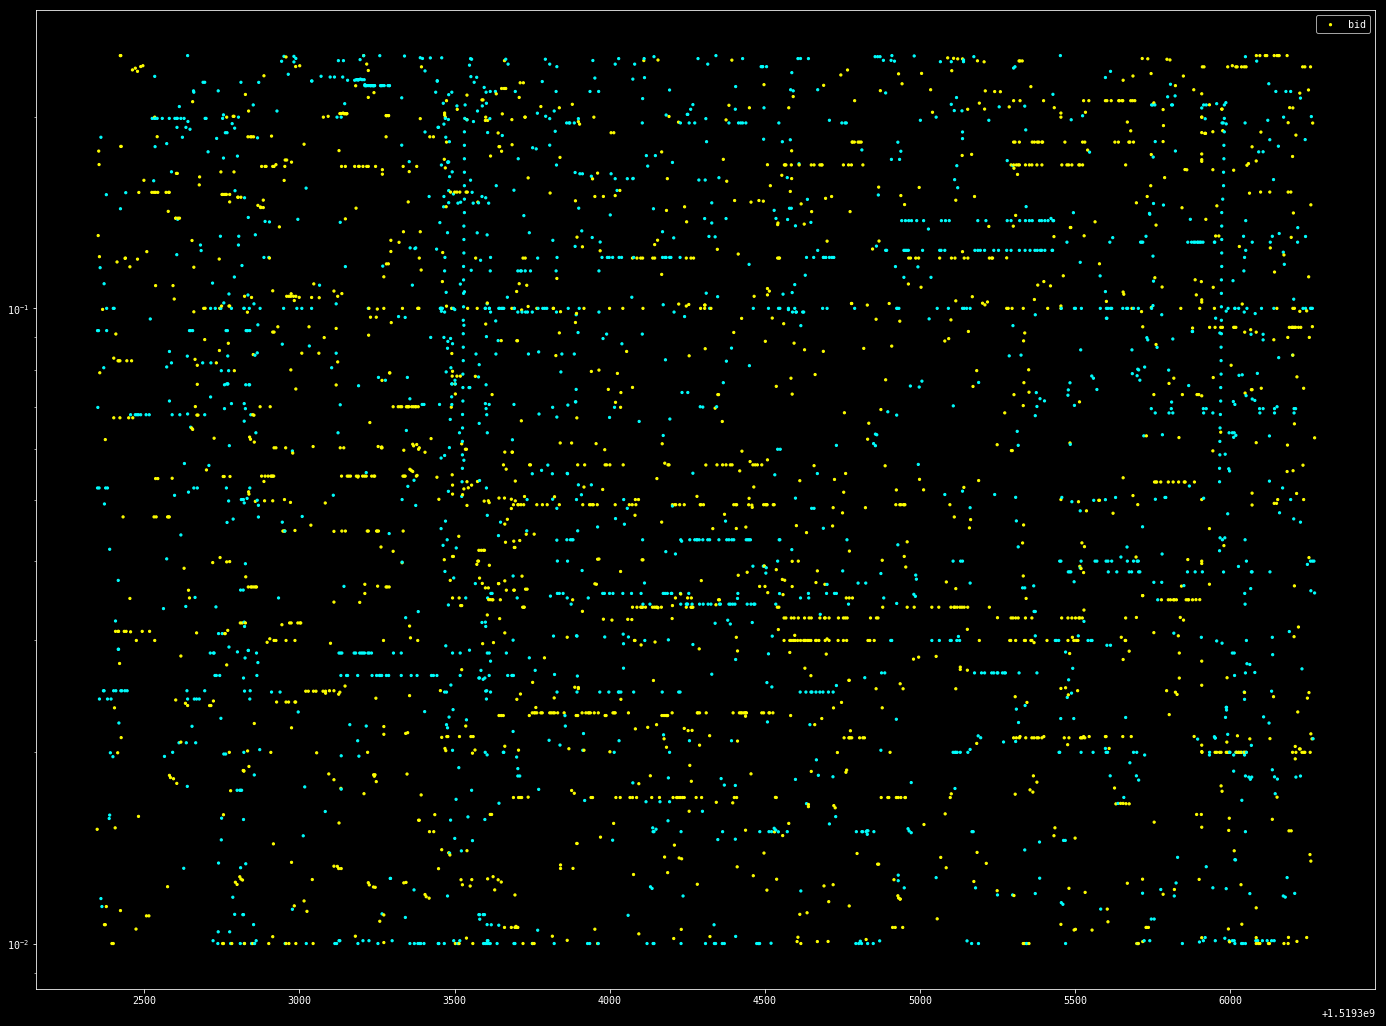

In [162]:
plotVolumeMap(cancelled, volFrom=0.01, volTo=0.25, log_scale=True)

### Created

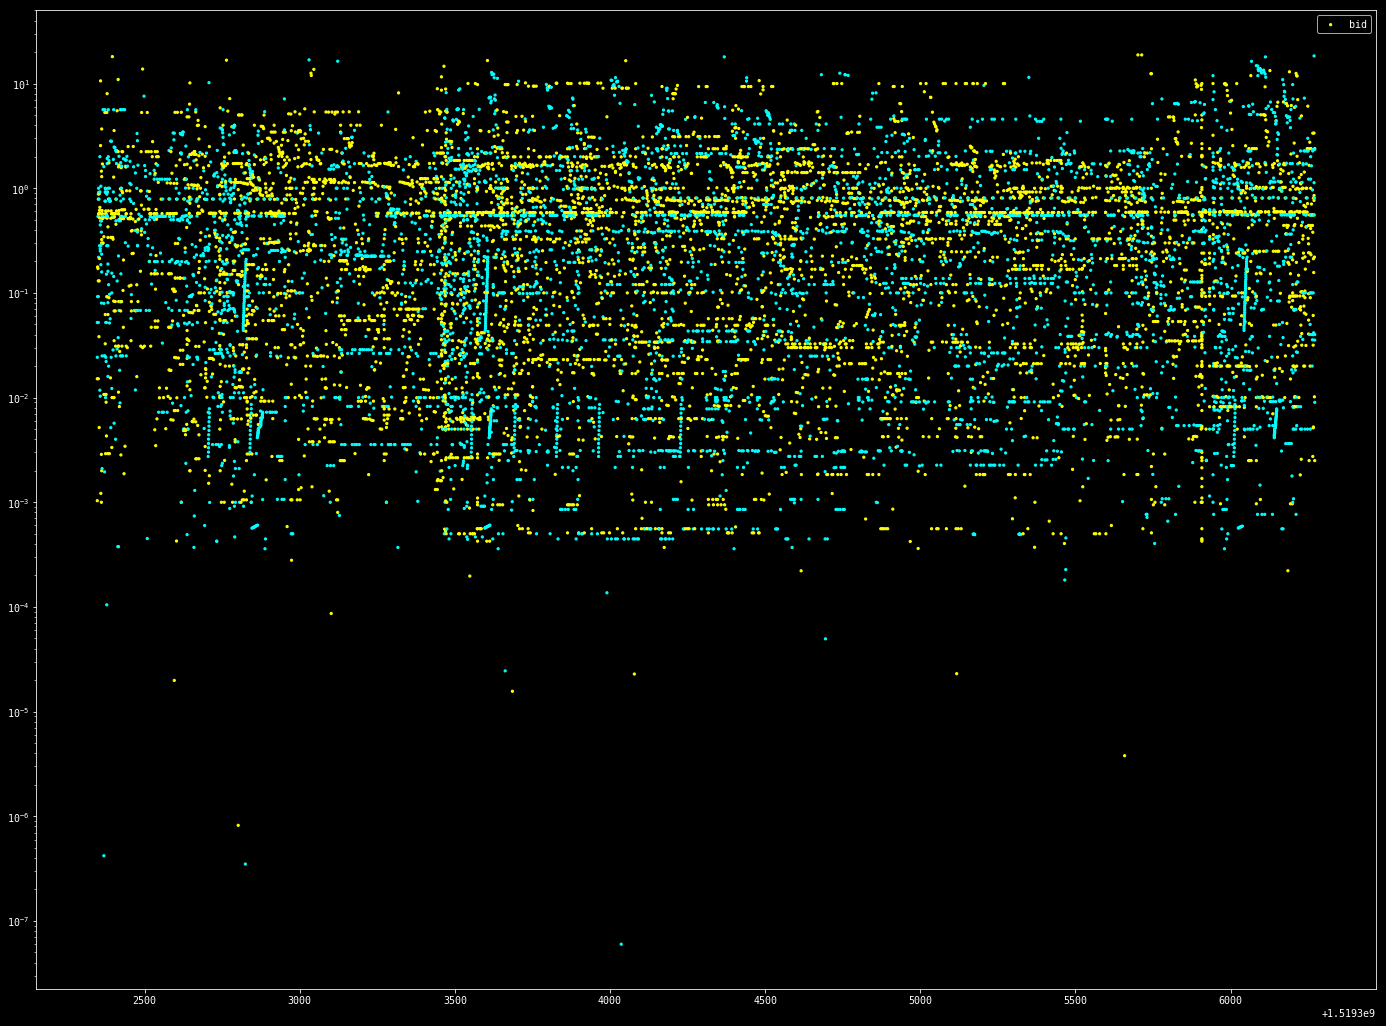

In [163]:
plotVolumeMap(created, volFrom=0, volTo=20, log_scale=True)

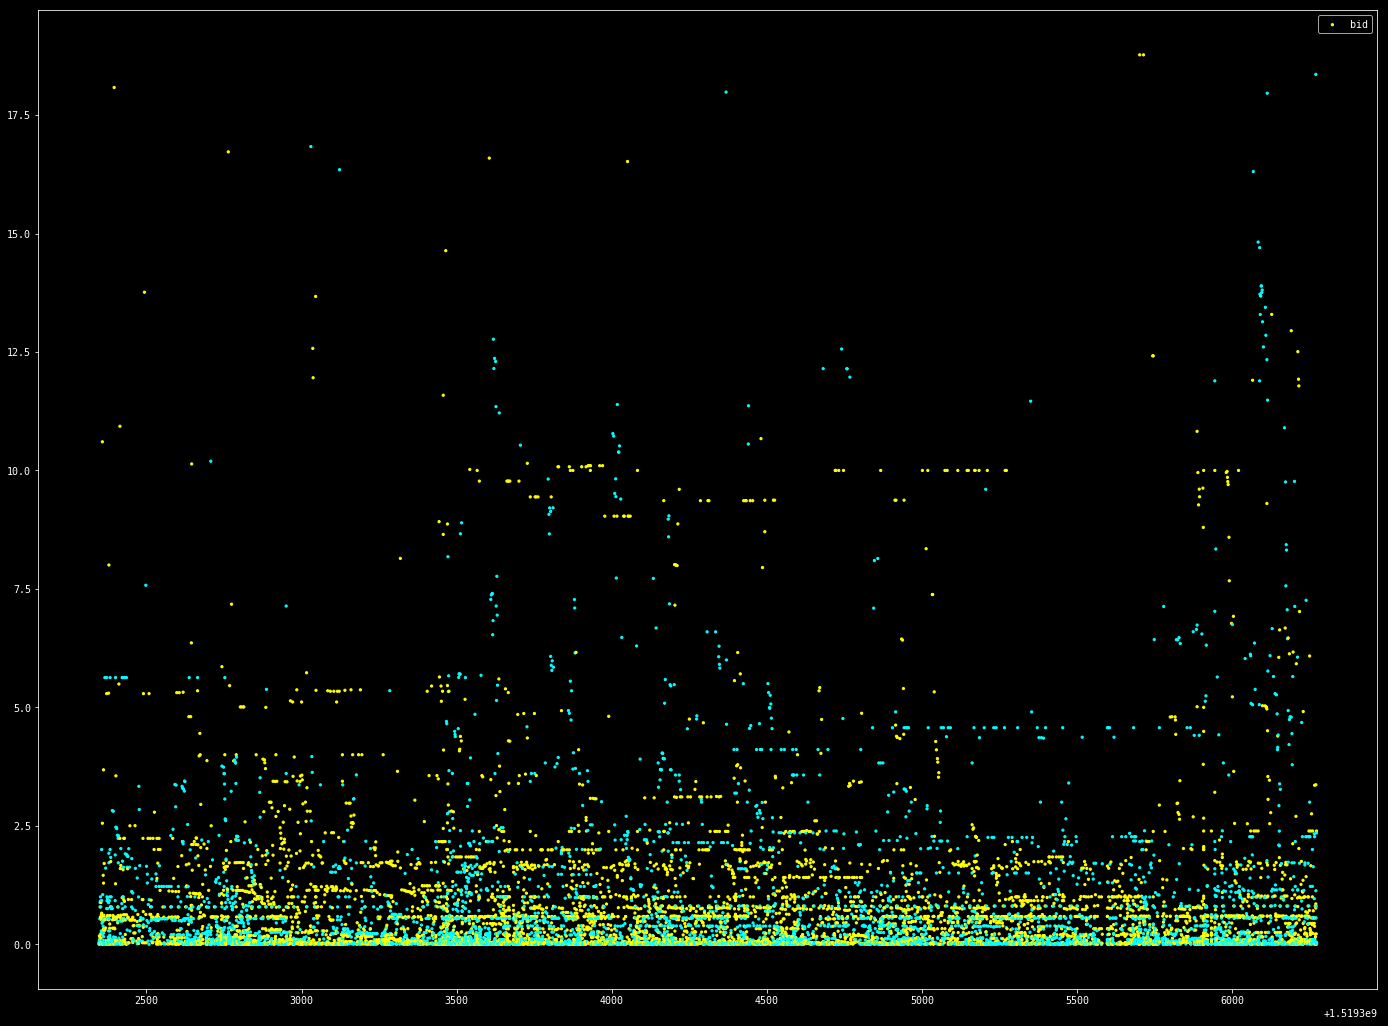

In [164]:
plotVolumeMap(created, volFrom=0, volTo=20, log_scale=False)

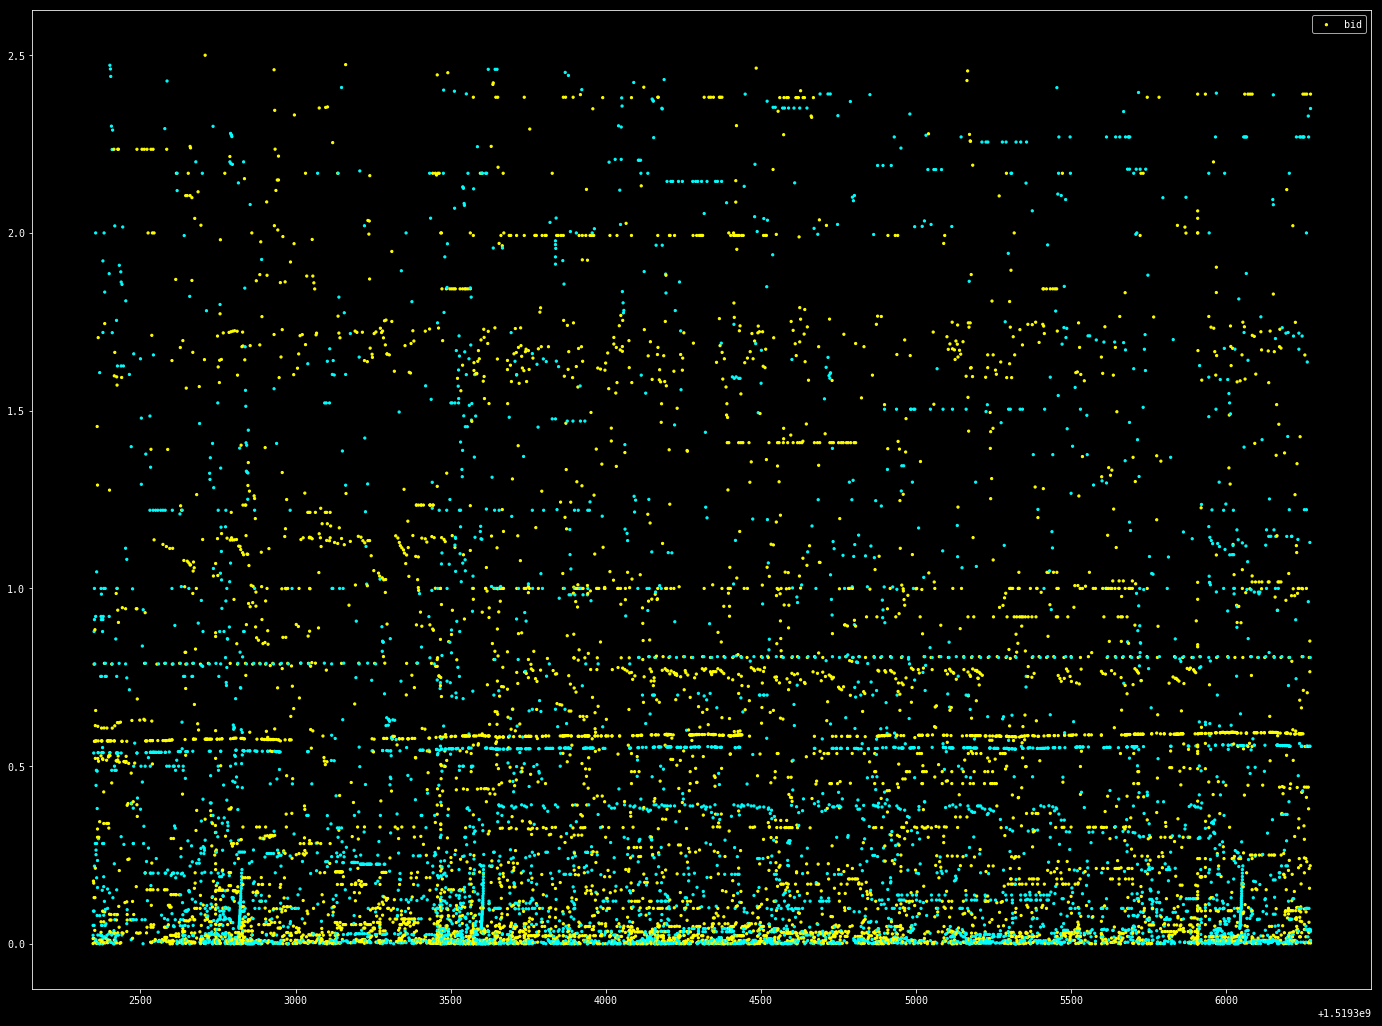

In [165]:
plotVolumeMap(created, volFrom=0, volTo=2.5, log_scale=False)

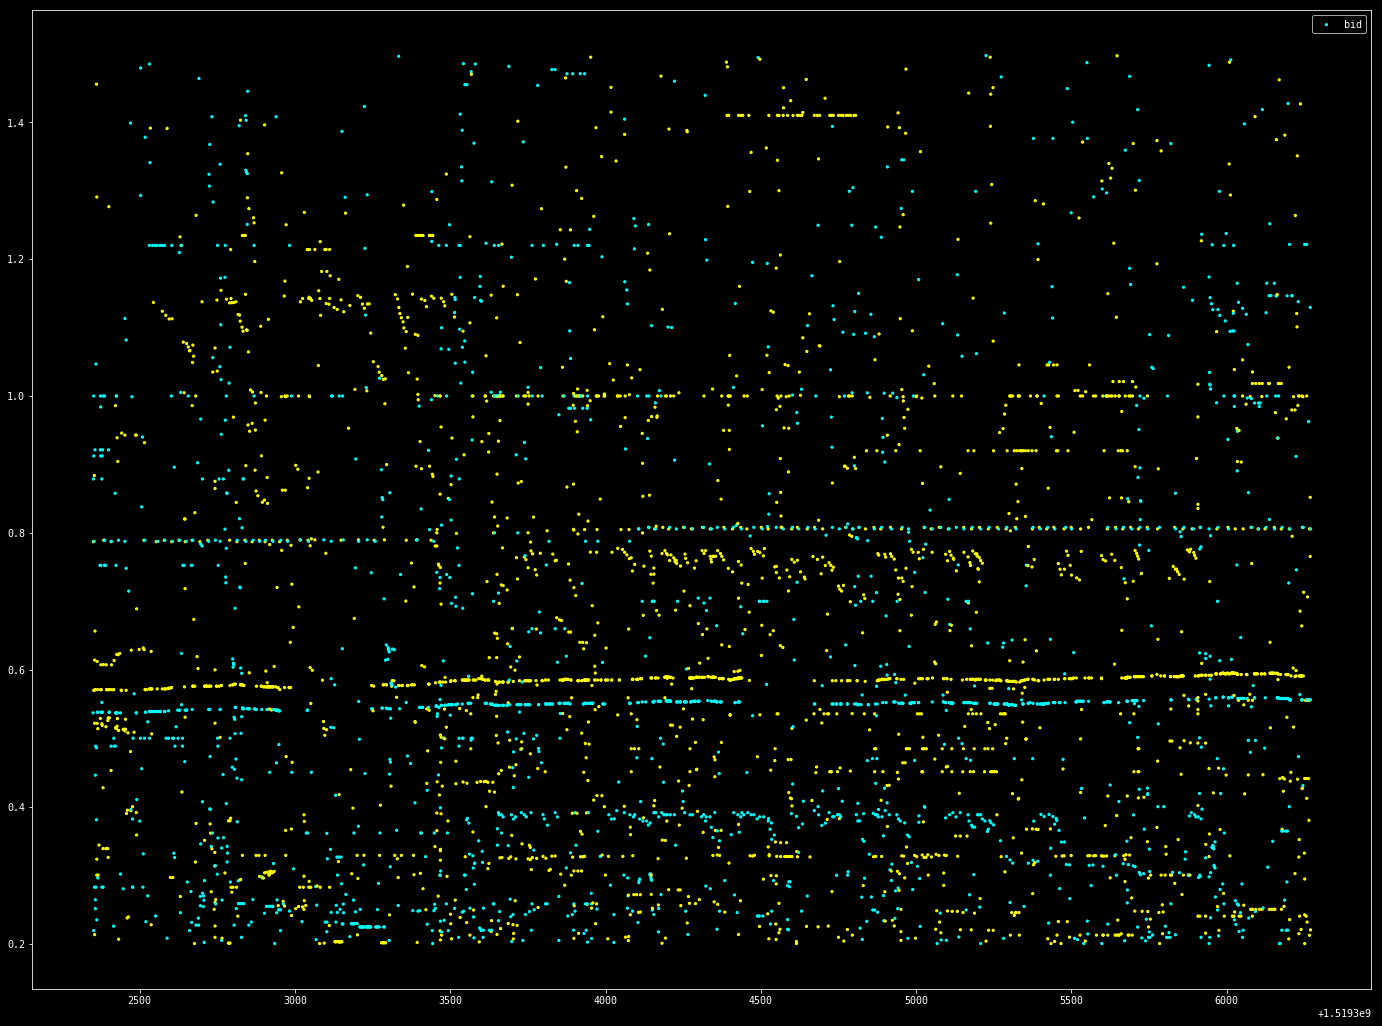

In [166]:
plotVolumeMap(created, volFrom=0.2, volTo=1.5, log_scale=False)

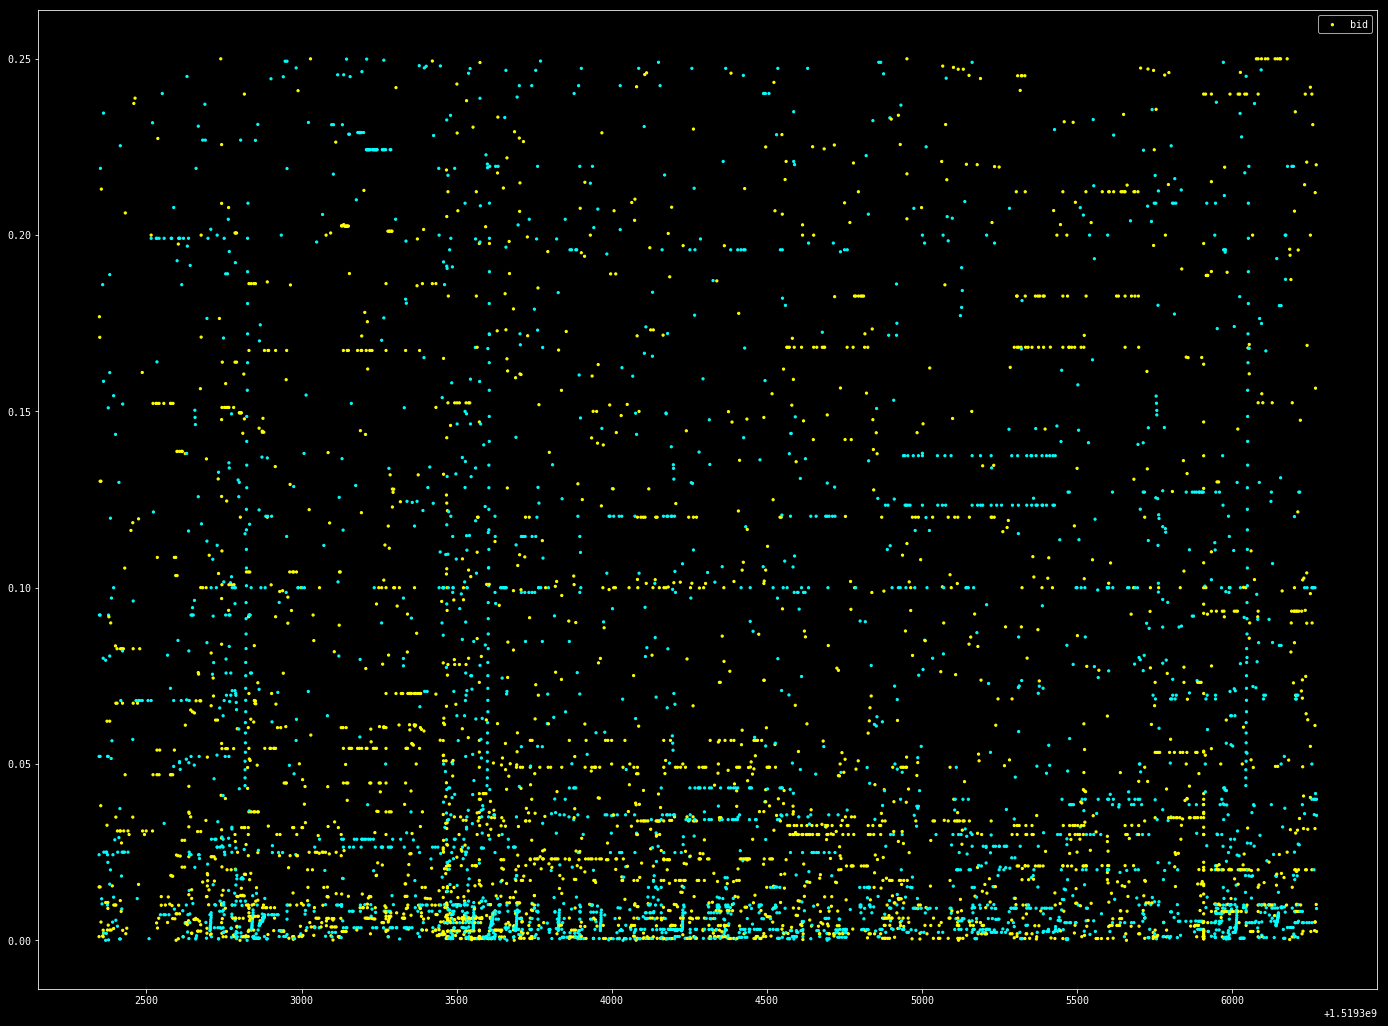

In [167]:
plotVolumeMap(created, volFrom=0.0, volTo=0.25, log_scale=False)

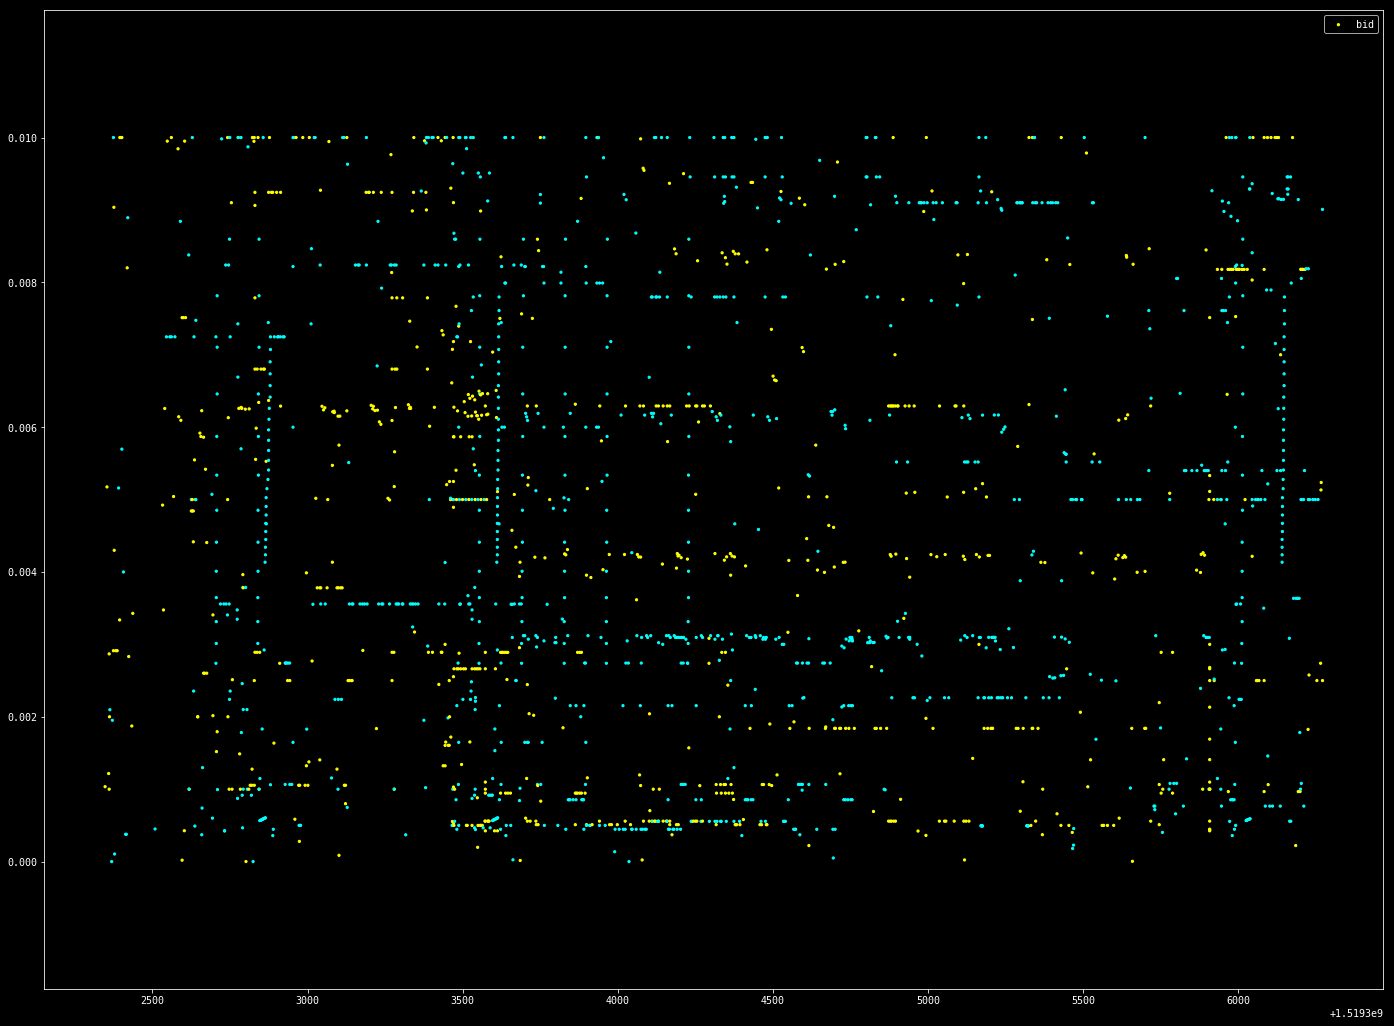

In [168]:
plotVolumeMap(created, volFrom=0.0, volTo=0.01, log_scale=False)

## Trades

In [180]:
def best_ba(orderbook):
    best_bids_asks = []

    for ts, ob in orderbook.items():
        try:
            best_bid = max(ob["bids"].keys())
        except: # sometimes L in max(L) is []
            continue
        try:
            best_ask = min(ob["asks"].keys())
        except:
            continue
        best_bids_asks.append((ts, best_bid, best_ask))

    best_bids_asks = pd.DataFrame.from_records(best_bids_asks, columns=["ts", "best_bid", "best_ask"], index="ts").sort_index()
    return best_bids_asks

def plot_best_ba(best_ba_df):
    bhys = []    # bid - horizontal - ys
    bhxmins = [] # bid - horizontal - xmins
    bhxmaxs = [] # ...
    bvxs = []
    bvymins = []
    bvymaxs = []
    ahys = []
    ahxmins = []
    ahxmaxs = []
    avxs = []
    avymins = []
    avymaxs = []

    bba_tuple = best_ba_df.to_records()
    for (ts1, b1, a1), (ts2, b2, a2) in zip(bba_tuple, bba_tuple[1:]): # bigram
        bhys.append(b1)
        bhxmins.append(ts1)
        bhxmaxs.append(ts2)
        bvxs.append(ts2)
        bvymins.append(b1)
        bvymaxs.append(b2)
        ahys.append(a1)
        ahxmins.append(ts1)
        ahxmaxs.append(ts2)
        avxs.append(ts2)
        avymins.append(a1)
        avymaxs.append(a2)

    plt.hlines(bhys, bhxmins, bhxmaxs, color="green", lw=1, alpha=1)
    plt.vlines(bvxs, bvymins, bvymaxs, color="green", lw=1, alpha=1)
    plt.hlines(ahys, ahxmins, ahxmaxs, color="red", lw=1, alpha=1)
    plt.vlines(avxs, avymins, avymaxs, color="red", lw=1, alpha=1)

def plot_trades(trades, size=1, zorder=10):
    trades_colors = list(map(lambda is_bid: "#00ff00" if is_bid else "#ff0000", trades.is_bid))
                              # TODO: fix 1h time diff
    plt.scatter((trades["ts"]+3600), trades["price"], s=trades["size"]*size, color=trades_colors, zorder=zorder)


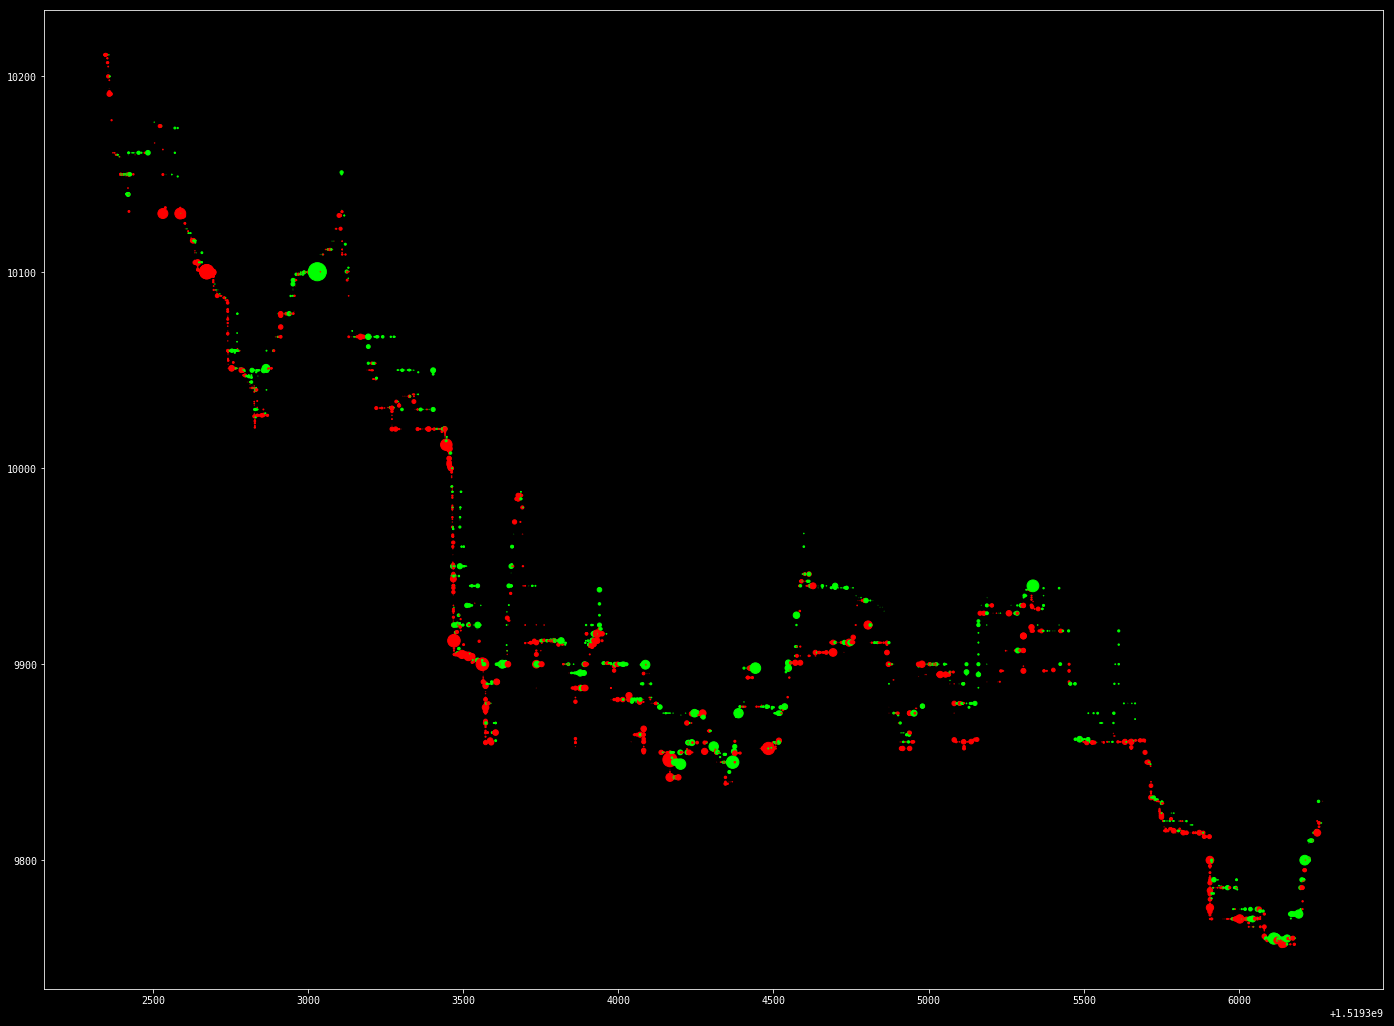

In [189]:
plt.figure(figsize=(24, 18))
plot_trades(trades, size=20.0, zorder=0)
plt.show()

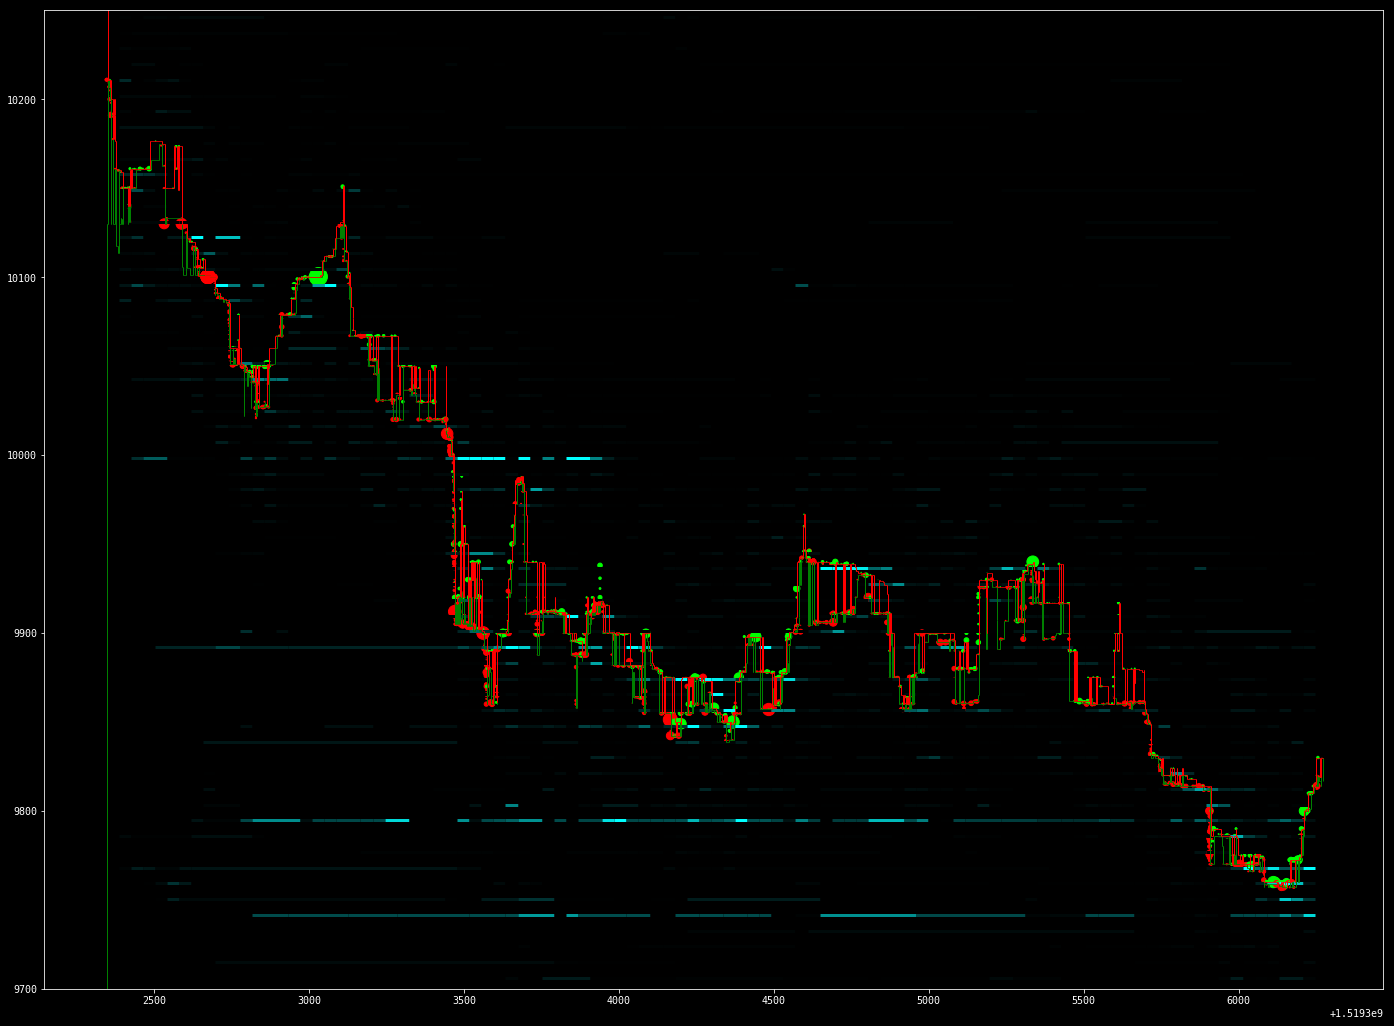

In [187]:
best_ba_df = best_ba(ob_dict)
plt.figure(figsize=(24, 18))

plot_best_ba(best_ba_df)
plot_trades(trades, size=20.0, zorder=0)

updates = to_updates(events, rejected, tick_bins_cnt = 100, step_bins_cnt = 100)
plot_price_levels(updates, zorder=0, max_threshold=100, min_threshold=0.01)

plt.ylim([9700, 10250])
plt.show()

### Created / Cancelled vs. Trades

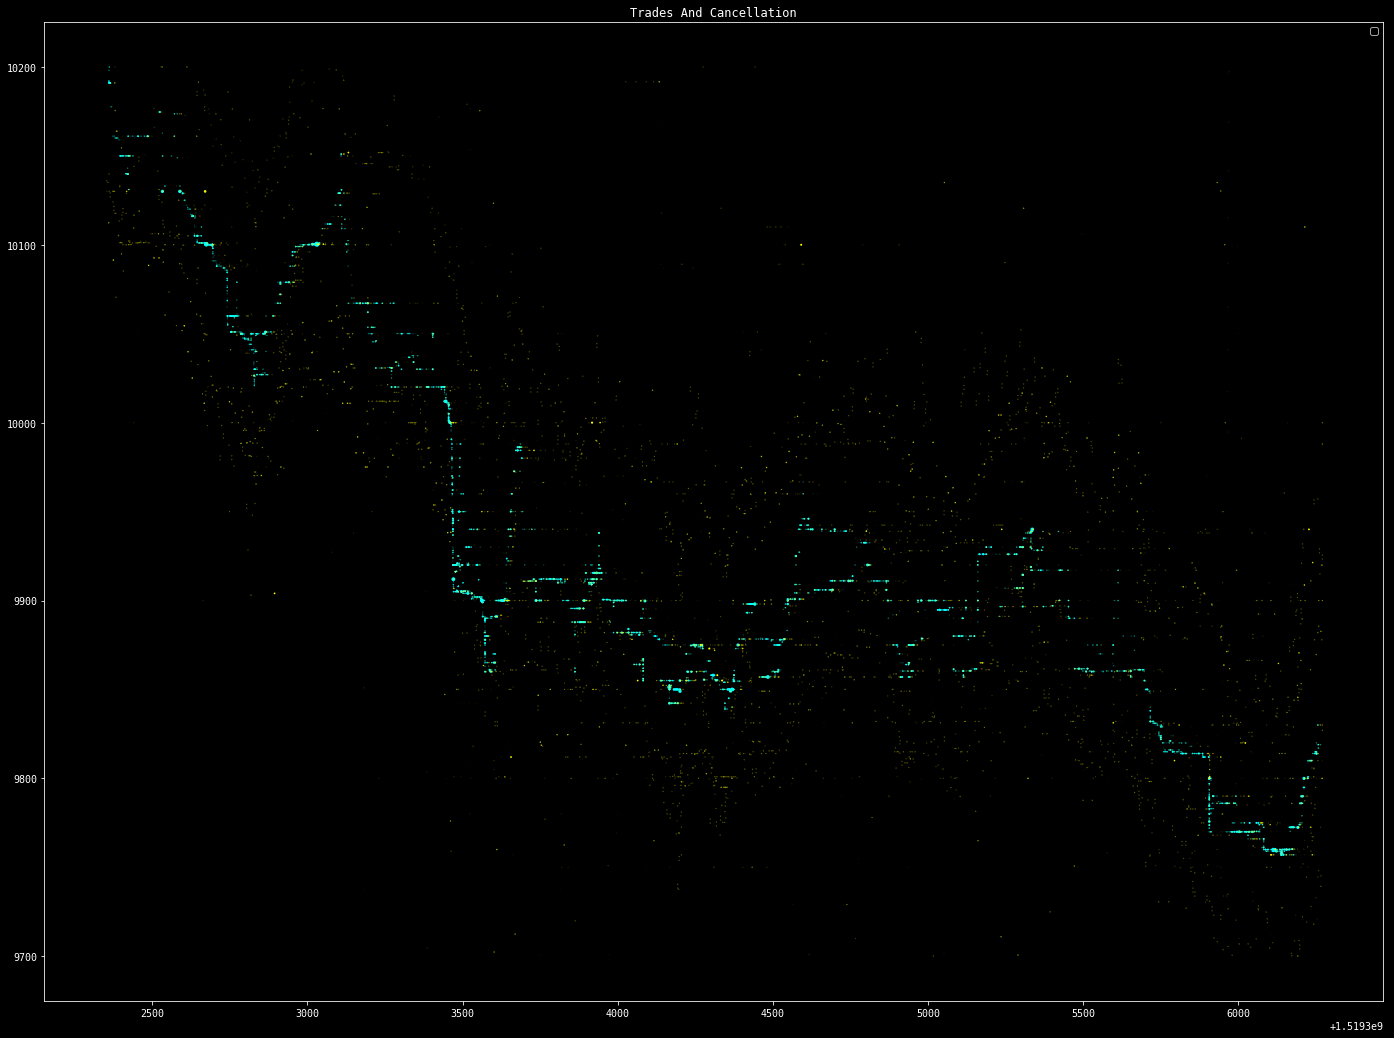

In [195]:
def plot_events(df, trades_df=None, min_price=None, max_price=None, log_scale=True):
    if min_price:
        df = df[(df["price"] > min_price)]
        if trades_df is not None:
            trades_df = trades_df[(trades_df["price"] > min_price)]
    if max_price:
        df =  df[(df["price"] < max_price)]
        if trades_df is not None:
            trades_df =  trades_df[(trades_df["price"] < max_price)]

    fig = plt.figure(figsize=(24, 18))
    ax = fig.add_subplot(111)

    if trades_df is not None:
        plt.title("Trades And Cancellation")
        plt.legend(["Trades", "Cancellation"])
        plt.scatter(trades_df["ts"]+3600, trades_df["price"], s=trades_df["size"], color="#00ffff")
        plt.scatter(df["ts"], df["price"], s=df["size"]/30, color="#ffff00")
    else:
        plt.scatter(df["ts"], df["price"], s=df["size"], color="#ffff00")
        plt.legend("Cancelled")
        plt.title("Cancellation")
    if log_scale:
        ax.set_yscale('log')

plot_events(cancelled, trades_df=trades, min_price=9700, max_price=10200.0, log_scale=False)
plt.show()


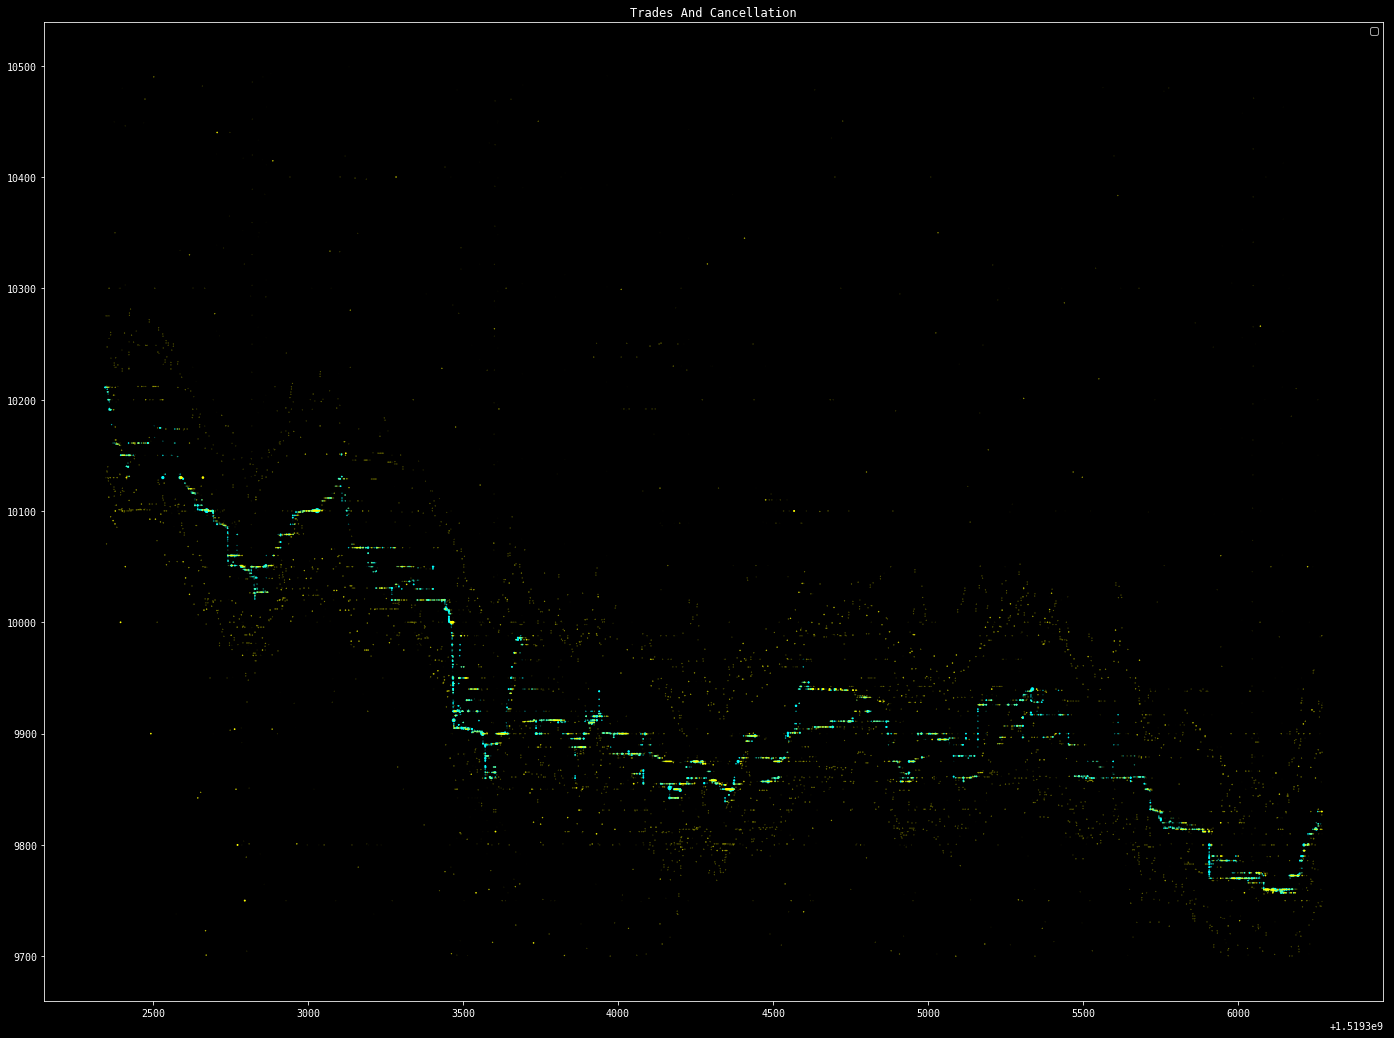

In [196]:
plot_events(created, trades_df=trades, min_price=9700, max_price=10500.0, log_scale=False)
plt.show()


## References

[1] http://rickyhan.com/jekyll/update/2017/09/24/visualizing-order-book.html

[2] http://parasec.net/transmission/order-book-visualisation/